In [18]:
from app.model_manager import ModelManager
from app.refresh_docs import RefreshDocs
import random 
from transformers import AutoTokenizer, BitsAndBytesConfig, AutoModelForCausalLM, pipeline, logging
logging.set_verbosity_error()
import gc
import torch
import numpy as np 
import time 
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity 
from itertools import product
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:

def clear_cuda_memory():
    """
    manual memory management to avoid memory errors with repeated model use
    """
    try:
        # sync/wait for all GPU operations to finish
        torch.cuda.synchronize()
    except Exception as e:
        print("Error during synchronization:", e)
    
    # garbage collection
    gc.collect()
    time.sleep(1)  # small delay
    
    # clears the CUDA cache and reset
    try:
        torch.cuda.empty_cache()
    except Exception as e:
        print("Error during empty_cache:", e) 
    try:
        torch.cuda.reset_peak_memory_stats()
    except Exception as e:
        print("Error during reset_peak_memory_stats:", e)
    time.sleep(1)

In [3]:


def evaluate_generated_answer(generated_answer, true_answer, threshold=0.6, max_retries=5):
    """
    evaluates whether a generated answer matches a true answer using multiple modern metrics:
      - Token-level F1 score: measures word-overlap after normalization.
      - Embedding similarity: cosine similarity between mean-pooled embeddings.
      - Zero-shot NLI: uses a natural language inference pipeline to assess entailment.
      - Text classification: uses a classification pipeline (as a proxy for relevance). 
    """
    
    # normalize and compute token-level F1
    def normalize(text: str) -> str:
        return text.strip().lower()
    
    norm_gen = normalize(generated_answer)
    norm_true = normalize(true_answer)
    
    # tokenize on whitespace.
    gen_tokens = norm_gen.split()
    true_tokens = norm_true.split()
    common_tokens = set(gen_tokens) & set(true_tokens)
    
    if not common_tokens:
        token_f1 = 0.0
    else:
        precision = len(common_tokens) / len(gen_tokens)
        recall = len(common_tokens) / len(true_tokens)
        token_f1 = 2 * (precision * recall) / (precision + recall)
    
    scores = {"token_f1": token_f1}
    
    # model names for the evaluation pipelines
    model_names = [
        "sentence-transformers/all-MiniLM-L6-v2", # embedding-based similarity.
        "cross-encoder/nli-roberta-base", # zero-shot NLI.
        "distilbert/distilbert-base-uncased-finetuned-sst-2-english" # text classification (relevance).
    ]
    
    # embedding cosine_similarity
    try:
        goal = "feature-extraction"
        # safe_generate_fit is expected to return embeddings for both texts. 
        embeddings = safe_generate_fit(generated_answer, true_answer, goal, model_names, max_retries=max_retries)
        # mean-pool embeddings for each text.
        pooled_gen = np.mean(np.array(embeddings[0]), axis=1).flatten()
        pooled_true = np.mean(np.array(embeddings[1]), axis=1).flatten()
        embedding_score = cosine_similarity([pooled_gen], [pooled_true])[0][0]
        scores["embedding_similarity"] = embedding_score
    except Exception as e:
        scores["embedding_similarity"] = 0.0
        print(f"Embedding similarity evaluation failed: {e}")
    
    # zero-shot NLI eval
    try:
        goal = "zero-shot-classification"
        # compares generated_answer to the true_answer as candidate.
        nli_result = safe_generate_fit(generated_answer, true_answer, goal, model_names, max_retries=max_retries)
        # s/b a dictionary with a "scores" field.
        nli_score = nli_result["scores"][0]
        scores["nli_score"] = nli_score
    except Exception as e:
        scores["nli_score"] = 0.0
        print(f"NLI evaluation failed: {e}")
    
    # text classification eval
    try:
        goal = "text-classification"
        # pipeline takes a concatenation of the texts.
        text_class_result = safe_generate_fit(generated_answer, true_answer, goal, model_names, max_retries=max_retries)
        text_class_score = text_class_result[0]["score"]
        scores["text_classification_score"] = text_class_score
    except Exception as e:
        scores["text_classification_score"] = 0.0
        print(f"Text classification evaluation failed: {e}")
    
    # aggregate threshold.
    num_metrics_good = sum(1 for score in scores.values() if isinstance(score, float) and score > threshold)
    scores["is_good_enough"] = (num_metrics_good >= 2)
    
    return scores 
    
def safe_generate_fit(response, keywords, goal, model_names, max_retries=5): 
    retries = 0
    while retries < max_retries:
        try:
            if goal == "feature-extraction":
                pipe = pipeline(goal, model=model_names[0])
                result = pipe([response, keywords])
                # clean up and return
                del pipe
                torch.cuda.empty_cache()
                return result
            
            elif goal == "zero-shot-classification":
                pipe = pipeline(goal, model=model_names[1])
                # use true answer as a candidate label
                result = pipe(response, candidate_labels=[keywords])
                del pipe
                torch.cuda.empty_cache()
                return result
            
            elif goal == "text-classification":
                pipe = pipeline(goal, model=model_names[2]) 
                result = pipe(response + " " + keywords)
                del pipe
                torch.cuda.empty_cache()
                return result
            
        except torch.cuda.OutOfMemoryError:
            print(f"OutOfMemoryError. Attempt {retries + 1} of {max_retries}")
            # clean up GPU memory.
            try:
                del pipe
            except Exception:
                pass
            torch.cuda.empty_cache()
            torch.cuda.reset_peak_memory_stats()
            gc.collect()
            time.sleep(5)
            retries += 1
    
    raise RuntimeError("Maximum retries reached in safe_generate_fit.")
     

In [4]:
import json
def load_file(fname): 
    with open(fname, "r", encoding="utf-8") as f:
        return json.load(f) 

def refresh(): 
    all_test_data = load_file("all_test_data.txt")
    cache_file = load_file('app/all_OGS_embedded_docs.json')
    
    all_sys_tests = []
    for i in range(len(cache_file['documents'])):
        # get tests for doc
        for t in all_test_data:
            if cache_file['documents'][i] == t['document']:
                tests = t['tests']
        # set system source
        if i in cache_file['cache_idxs'] :
            sys = 'CAG'
        else:
            sys = 'RAG'
    
        all_sys_tests.append({
            'document': cache_file['documents'][i],
            'tests': tests,
            'method': sys,
        })
    return all_sys_tests
#all_sys_tests[:2]

In [5]:
import re
import difflib
from typing import List, Tuple, Dict, Any
from sentence_transformers import SentenceTransformer, util 

def semantic_similarity(claim, passage):
    """ semantic (cosine) similarity between a claim and a passage. 
    """
    model = SentenceTransformer('all-MiniLM-L6-v2')
    # embeddings for both the claim and the passage
    claim_embedding = model.encode([claim], convert_to_tensor=True)
    passage_embedding = model.encode([passage], convert_to_tensor=True)
    
    # cosine similarity between the two embeddings
    cosine_score = util.cos_sim(claim_embedding, passage_embedding)
    return cosine_score.item()
    
def extract_claims(text):
    """ split the text into claims by sentence 
    """
    # Split by sentence-ending punctuation and filter out short fragments.
    sentences = re.split(r'(?<=[.!?])\s+', text)
    claims = [s.strip() for s in sentences if len(s.strip()) > 20]
    return claims

def retrieve_evidence(claim, documents, sim_threshold = 0.35):
    """ for a given claim, scan the documents and return passages that are at least somewhat similar
    """
    candidate_passages = []
    for doc in documents:
        sim = semantic_similarity(claim, doc) 
        if sim >= sim_threshold:
            candidate_passages.append(doc)
    return candidate_passages

def verify_claim(claim, candidate_passages, support_threshold = 0.45):
    """ determine if the claim is supported by any of the candidate passages. 
    """
    for passage in candidate_passages: 
        sim = semantic_similarity(claim, doc) 
        if sim >= support_threshold:
            return True
    return False

def secondary_validate_generated_answer(generated_answer, documents, aggregate_threshold=0.8):
    """ validate if the generated answer is supported by the documents.
    """
    claims = extract_claims(generated_answer)
    if not claims:
        return False, {"error": "No claims extracted from the generated answer."}
    
    supported_count = 0
    claim_details = {}

    idx = 0
    for claim in claims: 
        candidate_passages = retrieve_evidence(claim, documents) 
        is_supported = verify_claim(claim, candidate_passages) 
        claim_details[claim] = {
            "supported": is_supported,
            "evidence_found": len(candidate_passages)
        }
        if is_supported:
            supported_count += 1
        idx+=1
    support_ratio = supported_count / len(claims)
    is_valid = support_ratio >= aggregate_threshold
    
    return is_valid, {
        "support_ratio": support_ratio,
        "claim_details": claim_details
    }


In [6]:
divisors = [20, 30]
gen_methods = ['Greedy','Greedy', 'sampling']
temperatures = [0.2, 0.35, 0.5]
top_ks = [10, 30, 50]

grid = []

for d in divisors:
    max_cache_tokens = int(128000 / d)
    for method in gen_methods:
        if method == 'Greedy':
            grid.append({
                'divisor': d,
                'max_cache_tokens': max_cache_tokens,
                'gen_method': method,
                'temperature': None,
                'top_k': None
            })
        else:  # sampling
            for t, k in product(temperatures, top_ks):
                grid.append({
                    'divisor': d,
                    'max_cache_tokens': max_cache_tokens,
                    'gen_method': method,
                    'temperature': t,
                    'top_k': k
                })
print(grid[0])
print(len(grid))
print(len(grid)*3)
print(len(grid)*40*3)
(len(grid)*40*3*8)/60/60

{'divisor': 20, 'max_cache_tokens': 6400, 'gen_method': 'Greedy', 'temperature': None, 'top_k': None}
22
66
2640


5.866666666666666

In [7]:
all_answer_result = []
all_method_result = []
results = []
test_start_time = time.time()
for test_i in tqdm(range(3), desc="Iteration", position=0):
    grid_i = 0
    for test_round in tqdm(grid, desc="Grid Search", position=1, leave=False):
        # refresh files for random cache docs
        ref = RefreshDocs()
        ref.refresh('app/documents_rag.json', action="RAG") 
        refresh_dict = ref.refresh('app/all_OGS_embedded_docs.json', action="CACHE", max_cache_tokens=int(128000/test_round['divisor']))
        all_sys_tests = refresh() 
        
        # generate samples
        rag_tests = [doc for doc in all_sys_tests if doc['method'] == 'RAG']
        cag_tests = [doc for doc in all_sys_tests if doc['method'] == 'CAG']
        rando_rag = random.sample(rag_tests, min(20,len(cag_tests)))
        rando_cag = random.sample(cag_tests, min(20,len(cag_tests)))
        randos = []
        randos.extend(rando_rag)
        randos.extend(rando_cag)
    
        #clear mem
        clear_cuda_memory() 
        gb_value = torch.cuda.memory_allocated() / (1024**3)
        print(f"Memory i-{test_i}: {gb_value:.2f} GB") 
        
        mm = ModelManager()  
        
        n_answer_result = []
        n_method_result = []
        n_results = []
        
        
        for idx, doc in tqdm(enumerate(randos), desc="InnerTests", position=2, leave=False):
            rand_question = random.sample(list(doc['tests'].keys()), 1)[0]
            rand_answer = doc['tests'][rand_question]
            
            start_time = time.time()   
            response = mm.query_handler(rand_question, gen_method=test_round['gen_method'], temperature=test_round['temperature'], top_k=test_round['top_k'])
            end_time = time.time()
    
            # set rand_answer for better/expected compare
            if rand_answer == "No Answer":
                rand_answer = "As Northeastern's OGS assistant I do not have an access to that information."
            this_results = evaluate_generated_answer(response['output'], rand_answer)
    
            # set docs for secondary search
            if response['method'] == 'RAG':
                applicable_docs = response['RAG_Docs']
            else:
                applicable_docs = mm.cag.cag_docs
                
            #secondary evaluation
            if this_results['is_good_enough']:
                validate_overall = this_results['is_good_enough']
            else:
                validate_overall, details = secondary_validate_generated_answer(response['output'], applicable_docs)  
    
            #evaluate if Q is CAG but should be flipped CAG->Rag
            if rand_answer == "As Northeastern's OGS assistant I do not have an access to that information." and doc['method'] == 'CAG': 
                flip = True
                method = "RAG"
            else:
                flip = False
                method = doc['method']
    
            #correct RAG v CAG?
            meth_val = method == response['method']
    
            #did RAG get the right doc?
            if doc['method']=='RAG':
                RAG_doc_right = doc['document'] in applicable_docs
            else:
                RAG_doc_right = None
            
            n_answer_result.append(this_results)
            n_method_result.append(meth_val)
            n_results.append({
                'test_method': test_round,
                'doc': doc['document'],
                'query': rand_question,
                'answer_true': rand_answer,
                'answer_gen': response['output'],
                'results': this_results,
                'is_good_enough': this_results['is_good_enough'],
                'validate_secondary': validate_overall, # w secondary evaluation
                'sys_correct': meth_val,
                'method_used': response['method'],
                'method_sb': doc['method'],
                'method_dynamic': method,
                'flipped': flip,
                'response_time': end_time - start_time,
                'cache_check_time': response['cache_check_time'],
                'rag_right': RAG_doc_right,
                'cnt_docs': len(applicable_docs),
                'cnt_refdoc_chars': sum([len(doc.split()) for doc in applicable_docs]), 
                'cache_tok': refresh_dict['cache_tok']
            }) 
            
        all_answer_result.append(n_answer_result)
        all_method_result.append(n_method_result)
        
        # save results
        file_name = f"TESTSYS_iteration_results_n{test_i}_g{grid_i }.json" 
        
        with open(file_name, "w", encoding="utf-8") as f:
            json.dump(n_results, f, indent=4) 
        results.append(n_results)
        
        time.sleep(2)
        #clear mem
        clear_cuda_memory() 
        gb_value = torch.cuda.memory_allocated() / (1024**3)
        print(f"Memory i-{test_i}: {gb_value:.2f} GB") 
        del mm 
        clear_cuda_memory() 
        gb_value = torch.cuda.memory_allocated() / (1024**3)
        print(f"Memory i-{test_i}: {gb_value:.2f} GB") 
        grid_i+=1
    
with open("TESTSYS_overall_results.json", "w", encoding="utf-8") as f:
    json.dump(results, f, indent=4)
with open("TESTSYS_all_method_result.json", "w", encoding="utf-8") as f:
    json.dump(all_method_result, f, indent=4)
with open("TESTSYS_all_answer_result.json", "w", encoding="utf-8") as f:
    json.dump(all_answer_result, f, indent=4)

Grid Search:   0%|          | 0/22 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Memory i-0: 2.20 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]



InnerTests: 0it [00:00, ?it/s]

InnerTests: 1it [00:09,  9.89s/it]

InnerTests: 2it [00:16,  7.97s/it]

InnerTests: 3it [00:33, 12.30s/it]

InnerTests: 4it [00:50, 14.14s/it]

InnerTests: 5it [01:16, 18.15s/it]

InnerTests: 6it [01:31, 17.20s/it]

InnerTests: 7it [01:56, 19.73s/it]

InnerTests: 8it [02:10, 18.06s/it]

InnerTests: 9it [03:03, 28.93s/it]

InnerTests: 10it [03:23, 26.05s/it]

InnerTests: 11it [03:36, 22.05s/it]

InnerTests: 12it [04:41, 35.16s/it]

InnerTests: 13it [04:52, 27.89s/it]

InnerTests: 14it [05:04, 22.90s/it]

InnerTests: 15it [05:47, 29.21s/it]

InnerTests: 16it [07:35, 52.79s/it]

InnerTests: 17it [08:44, 57.71s/it]

InnerTests: 18it [08:52, 42.63s/it]

InnerTests: 19it [08:57, 31.36s/it]

InnerTests: 20it [09:02, 23.43s/it]

InnerTests: 21it [09:05, 17.44s/it]

InnerTests: 22it [09:19, 16.31s/it]

InnerTests: 23it [09:27, 13.77s/it]

InnerTests: 24it [10:12, 23.35s/it]

InnerTests: 25it [10:19, 18.24s/it]

InnerTests: 26it [11:03, 25.93s/it]

InnerTests: 2

Memory i-0: 6.88 GB



Grid Search:   5%|▍         | 1/22 [17:43<6:12:10, 1063.36s/it]

Memory i-0: 2.20 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Memory i-0: 2.21 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]



InnerTests: 0it [00:00, ?it/s]

InnerTests: 1it [00:59, 59.44s/it]

InnerTests: 2it [01:10, 31.13s/it]

InnerTests: 3it [01:16, 19.75s/it]

InnerTests: 4it [01:28, 16.37s/it]

InnerTests: 5it [01:34, 12.93s/it]

InnerTests: 6it [01:43, 11.39s/it]

InnerTests: 7it [01:50, 10.01s/it]

InnerTests: 8it [02:33, 20.49s/it]

InnerTests: 9it [02:39, 15.84s/it]

InnerTests: 10it [02:42, 11.90s/it]

InnerTests: 11it [02:56, 12.51s/it]

InnerTests: 12it [05:52, 62.23s/it]

InnerTests: 13it [06:03, 46.81s/it]

InnerTests: 14it [06:05, 33.28s/it]

InnerTests: 15it [06:09, 24.35s/it]

InnerTests: 16it [06:13, 18.49s/it]

InnerTests: 17it [06:21, 15.14s/it]

InnerTests: 18it [07:04, 23.45s/it]

InnerTests: 19it [07:10, 18.25s/it]

InnerTests: 20it [07:37, 21.00s/it]

InnerTests: 21it [07:42, 16.05s/it]

InnerTests: 22it [08:02, 17.24s/it]

InnerTests: 23it [08:22, 18.27s/it]

InnerTests: 24it [08:25, 13.51s/it]

InnerTests: 25it [08:47, 16.27s/it]

InnerTests: 26it [09:16, 19.85s/it]

InnerTests: 2

Memory i-0: 6.90 GB



Grid Search:   9%|▉         | 2/22 [32:23<5:18:33, 955.65s/it] 

Memory i-0: 2.21 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Memory i-0: 2.21 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]



InnerTests: 0it [00:00, ?it/s]

InnerTests: 1it [00:10, 10.94s/it]

InnerTests: 2it [00:15,  7.45s/it]

InnerTests: 3it [00:32, 11.43s/it]

InnerTests: 4it [00:35,  8.42s/it]

InnerTests: 5it [00:38,  6.21s/it]

InnerTests: 6it [00:46,  6.75s/it]

InnerTests: 7it [01:03, 10.31s/it]

InnerTests: 8it [01:07,  8.23s/it]

InnerTests: 9it [01:12,  7.23s/it]

InnerTests: 10it [01:17,  6.59s/it]

InnerTests: 11it [01:25,  7.07s/it]

InnerTests: 12it [01:28,  5.87s/it]

InnerTests: 13it [01:37,  6.71s/it]

InnerTests: 14it [01:56, 10.30s/it]

InnerTests: 15it [02:20, 14.55s/it]

InnerTests: 16it [02:23, 11.10s/it]

InnerTests: 17it [02:38, 12.09s/it]

InnerTests: 18it [02:44, 10.35s/it]

InnerTests: 19it [02:48,  8.46s/it]

InnerTests: 20it [03:55, 26.04s/it]

InnerTests: 21it [04:16, 24.64s/it]

InnerTests: 22it [04:26, 20.23s/it]

InnerTests: 23it [04:45, 19.89s/it]

InnerTests: 24it [06:19, 41.98s/it]

InnerTests: 25it [06:59, 41.38s/it]

InnerTests: 26it [07:20, 35.21s/it]

InnerTests: 2

Memory i-0: 6.90 GB



Grid Search:  14%|█▎        | 3/22 [50:58<5:25:38, 1028.35s/it]

Memory i-0: 2.21 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Memory i-0: 2.21 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]



InnerTests: 0it [00:00, ?it/s]

InnerTests: 1it [00:34, 34.98s/it]

InnerTests: 2it [00:50, 23.55s/it]

InnerTests: 3it [01:13, 23.37s/it]

InnerTests: 4it [01:26, 19.05s/it]

InnerTests: 5it [01:35, 15.58s/it]

InnerTests: 6it [01:46, 14.00s/it]

InnerTests: 7it [01:53, 11.63s/it]

InnerTests: 8it [01:58,  9.73s/it]

InnerTests: 9it [02:09,  9.86s/it]

InnerTests: 10it [02:44, 17.88s/it]

InnerTests: 11it [02:48, 13.39s/it]

InnerTests: 12it [03:08, 15.50s/it]

InnerTests: 13it [03:15, 12.92s/it]

InnerTests: 14it [03:27, 12.62s/it]

InnerTests: 15it [03:37, 11.78s/it]

InnerTests: 16it [03:40,  9.19s/it]

InnerTests: 17it [03:44,  7.82s/it]

InnerTests: 18it [03:54,  8.29s/it]

InnerTests: 19it [04:06,  9.49s/it]

InnerTests: 20it [04:34, 15.11s/it]

InnerTests: 21it [04:50, 15.27s/it]

InnerTests: 22it [04:51, 11.13s/it]

InnerTests: 23it [05:02, 11.04s/it]

InnerTests: 24it [05:52, 22.71s/it]

InnerTests: 25it [06:22, 24.69s/it]

InnerTests: 26it [06:28, 19.23s/it]

InnerTests: 2

Memory i-0: 6.90 GB



Grid Search:  18%|█▊        | 4/22 [1:07:25<5:03:39, 1012.19s/it]

Memory i-0: 2.21 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Memory i-0: 2.21 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]



InnerTests: 0it [00:00, ?it/s]

InnerTests: 1it [00:19, 19.06s/it]

InnerTests: 2it [00:24, 11.01s/it]

InnerTests: 3it [00:50, 18.02s/it]

InnerTests: 4it [01:03, 15.76s/it]

InnerTests: 5it [01:15, 14.65s/it]

InnerTests: 6it [01:41, 18.35s/it]

InnerTests: 7it [01:57, 17.51s/it]

InnerTests: 8it [02:00, 12.98s/it]

InnerTests: 9it [02:11, 12.28s/it]

InnerTests: 10it [02:13,  9.26s/it]

InnerTests: 11it [02:16,  7.38s/it]

InnerTests: 12it [02:22,  6.79s/it]

InnerTests: 13it [02:24,  5.47s/it]

InnerTests: 14it [02:26,  4.46s/it]

InnerTests: 15it [02:43,  8.28s/it]

InnerTests: 16it [03:02, 11.42s/it]

InnerTests: 17it [03:12, 10.93s/it]

InnerTests: 18it [03:32, 13.78s/it]

InnerTests: 19it [03:56, 16.72s/it]

InnerTests: 20it [04:00, 13.05s/it]

InnerTests: 21it [04:17, 14.16s/it]

InnerTests: 22it [04:33, 14.82s/it]

InnerTests: 23it [04:59, 18.06s/it]

InnerTests: 24it [05:19, 18.55s/it]

                                   

Memory i-0: 5.83 GB



Grid Search:  23%|██▎       | 5/22 [1:13:38<3:41:23, 781.41s/it] 

Memory i-0: 2.21 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Memory i-0: 2.21 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]



InnerTests: 0it [00:00, ?it/s]

InnerTests: 1it [00:02,  2.37s/it]

InnerTests: 2it [00:17,  9.85s/it]

InnerTests: 3it [00:28, 10.45s/it]

InnerTests: 4it [00:35,  8.88s/it]

InnerTests: 5it [00:37,  6.69s/it]

InnerTests: 6it [00:46,  7.42s/it]

InnerTests: 7it [00:49,  5.78s/it]

InnerTests: 8it [01:31, 17.42s/it]

InnerTests: 9it [01:44, 16.17s/it]

InnerTests: 10it [02:13, 20.13s/it]

InnerTests: 11it [02:19, 15.54s/it]

InnerTests: 12it [02:23, 12.26s/it]

InnerTests: 13it [02:50, 16.68s/it]

InnerTests: 14it [04:48, 47.39s/it]

InnerTests: 15it [04:56, 35.34s/it]

InnerTests: 16it [05:40, 37.85s/it]

InnerTests: 17it [05:43, 27.41s/it]

InnerTests: 18it [06:04, 25.43s/it]

InnerTests: 19it [06:10, 19.79s/it]

InnerTests: 20it [07:16, 33.68s/it]

InnerTests: 21it [07:34, 28.84s/it]

InnerTests: 22it [07:36, 20.74s/it]

InnerTests: 23it [07:45, 17.20s/it]

InnerTests: 24it [07:49, 13.30s/it]

InnerTests: 25it [08:22, 19.16s/it]

InnerTests: 26it [08:53, 22.90s/it]

InnerTests: 2

Memory i-0: 6.81 GB



Grid Search:  27%|██▋       | 6/22 [1:27:48<3:34:39, 804.98s/it]

Memory i-0: 2.21 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Memory i-0: 2.21 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]



InnerTests: 0it [00:00, ?it/s]

InnerTests: 1it [00:24, 24.12s/it]

InnerTests: 2it [00:35, 16.71s/it]

InnerTests: 3it [00:52, 16.56s/it]

InnerTests: 4it [01:15, 19.31s/it]

InnerTests: 5it [01:52, 25.53s/it]

InnerTests: 6it [02:34, 31.40s/it]

InnerTests: 7it [02:49, 25.75s/it]

InnerTests: 8it [02:55, 19.64s/it]

InnerTests: 9it [03:04, 16.27s/it]

InnerTests: 10it [03:09, 12.75s/it]

InnerTests: 11it [03:12,  9.69s/it]

InnerTests: 12it [03:16,  8.12s/it]

InnerTests: 13it [04:24, 26.25s/it]

InnerTests: 14it [05:10, 32.33s/it]

InnerTests: 15it [05:16, 24.16s/it]

InnerTests: 16it [07:34, 58.46s/it]

InnerTests: 17it [07:42, 43.31s/it]

InnerTests: 18it [07:46, 31.60s/it]

InnerTests: 19it [07:51, 23.59s/it]

InnerTests: 20it [07:55, 17.54s/it]

InnerTests: 21it [08:01, 14.27s/it]

InnerTests: 22it [08:05, 11.07s/it]

InnerTests: 23it [08:21, 12.72s/it]

InnerTests: 24it [08:26, 10.25s/it]

InnerTests: 25it [08:30,  8.48s/it]

InnerTests: 26it [08:57, 13.97s/it]

InnerTests: 2

Memory i-0: 6.43 GB



Grid Search:  32%|███▏      | 7/22 [1:43:17<3:31:20, 845.38s/it]

Memory i-0: 2.21 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Memory i-0: 2.21 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]



InnerTests: 0it [00:00, ?it/s]

InnerTests: 1it [00:07,  7.30s/it]

InnerTests: 2it [00:22, 12.10s/it]

InnerTests: 3it [00:47, 17.89s/it]

InnerTests: 4it [01:00, 15.82s/it]

InnerTests: 5it [01:24, 18.85s/it]

InnerTests: 6it [01:26, 13.25s/it]

InnerTests: 7it [01:46, 15.20s/it]

InnerTests: 8it [02:13, 19.15s/it]

InnerTests: 9it [02:28, 17.84s/it]

InnerTests: 10it [02:31, 13.24s/it]

InnerTests: 11it [02:57, 17.15s/it]

InnerTests: 12it [04:31, 40.56s/it]

InnerTests: 13it [04:41, 31.19s/it]

InnerTests: 14it [05:00, 27.65s/it]

InnerTests: 15it [05:12, 22.83s/it]

InnerTests: 16it [05:22, 19.08s/it]

InnerTests: 17it [05:29, 15.33s/it]

InnerTests: 18it [05:44, 15.29s/it]

InnerTests: 19it [05:59, 15.22s/it]

InnerTests: 20it [06:12, 14.65s/it]

InnerTests: 21it [06:21, 12.67s/it]

InnerTests: 22it [06:30, 11.67s/it]

InnerTests: 23it [07:01, 17.65s/it]

InnerTests: 24it [07:18, 17.31s/it]

InnerTests: 25it [08:28, 33.15s/it]

InnerTests: 26it [08:43, 27.56s/it]

InnerTests: 2

Memory i-0: 6.79 GB



Grid Search:  36%|███▋      | 8/22 [1:58:54<3:24:03, 874.51s/it]

Memory i-0: 2.21 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Memory i-0: 2.21 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]



InnerTests: 0it [00:00, ?it/s]

InnerTests: 1it [00:42, 42.34s/it]

InnerTests: 2it [01:30, 45.88s/it]

InnerTests: 3it [02:55, 63.49s/it]

InnerTests: 4it [05:07, 90.62s/it]

InnerTests: 5it [05:12, 59.84s/it]

InnerTests: 6it [05:18, 41.38s/it]

InnerTests: 7it [05:19, 28.42s/it]

InnerTests: 8it [05:24, 20.73s/it]

InnerTests: 9it [05:26, 14.97s/it]

InnerTests: 10it [05:28, 11.06s/it]

InnerTests: 11it [06:55, 34.22s/it]

InnerTests: 12it [07:04, 26.50s/it]

InnerTests: 13it [07:13, 21.38s/it]

InnerTests: 14it [07:29, 19.66s/it]

InnerTests: 15it [07:42, 17.60s/it]

InnerTests: 16it [07:54, 15.96s/it]

InnerTests: 17it [08:04, 14.04s/it]

InnerTests: 18it [08:14, 12.82s/it]

InnerTests: 19it [08:51, 20.26s/it]

InnerTests: 20it [08:57, 15.95s/it]

InnerTests: 21it [09:12, 15.50s/it]

InnerTests: 22it [09:28, 15.75s/it]

InnerTests: 23it [10:42, 33.33s/it]

InnerTests: 24it [11:05, 30.09s/it]

InnerTests: 25it [11:14, 23.86s/it]

InnerTests: 26it [11:25, 19.90s/it]

InnerTests: 2

Memory i-0: 6.67 GB



Grid Search:  41%|████      | 9/22 [2:16:05<3:20:04, 923.39s/it]

Memory i-0: 2.21 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Memory i-0: 2.21 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]



InnerTests: 0it [00:00, ?it/s]

InnerTests: 1it [00:17, 17.06s/it]

InnerTests: 2it [01:04, 34.84s/it]

InnerTests: 3it [01:15, 23.95s/it]

InnerTests: 4it [02:05, 34.38s/it]

InnerTests: 5it [02:08, 22.84s/it]

InnerTests: 6it [03:14, 37.75s/it]

InnerTests: 7it [03:38, 33.02s/it]

InnerTests: 8it [03:58, 28.94s/it]

InnerTests: 9it [04:01, 21.05s/it]

InnerTests: 10it [04:04, 15.23s/it]

InnerTests: 11it [04:07, 11.67s/it]

InnerTests: 12it [04:16, 10.80s/it]

InnerTests: 13it [04:21,  9.10s/it]

InnerTests: 14it [04:30,  8.85s/it]

InnerTests: 15it [04:33,  7.16s/it]

InnerTests: 16it [04:43,  8.15s/it]

InnerTests: 17it [06:40, 40.73s/it]

InnerTests: 18it [06:58, 33.86s/it]

InnerTests: 19it [07:00, 24.51s/it]

InnerTests: 20it [07:23, 23.89s/it]

InnerTests: 21it [07:25, 17.34s/it]

InnerTests: 22it [08:10, 25.66s/it]

InnerTests: 23it [09:44, 46.29s/it]

InnerTests: 24it [09:54, 35.20s/it]

InnerTests: 25it [09:59, 26.35s/it]

InnerTests: 26it [10:03, 19.47s/it]

InnerTests: 2

Memory i-0: 6.77 GB



Grid Search:  45%|████▌     | 10/22 [2:32:51<3:09:48, 949.01s/it]

Memory i-0: 2.21 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Memory i-0: 2.21 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]



InnerTests: 0it [00:00, ?it/s]

InnerTests: 1it [00:05,  5.24s/it]

InnerTests: 2it [00:16,  8.53s/it]

InnerTests: 3it [01:01, 25.48s/it]

InnerTests: 4it [01:26, 25.03s/it]

InnerTests: 5it [01:47, 23.64s/it]

InnerTests: 6it [03:53, 58.69s/it]

InnerTests: 7it [04:09, 44.43s/it]

InnerTests: 8it [04:19, 33.59s/it]

InnerTests: 9it [04:26, 25.19s/it]

InnerTests: 10it [05:36, 39.22s/it]

InnerTests: 11it [05:53, 32.30s/it]

InnerTests: 12it [06:45, 38.27s/it]

InnerTests: 13it [07:05, 32.94s/it]

InnerTests: 14it [07:22, 27.93s/it]

InnerTests: 15it [07:47, 27.22s/it]

InnerTests: 16it [08:48, 37.40s/it]

InnerTests: 17it [09:44, 42.75s/it]

InnerTests: 18it [09:58, 34.36s/it]

InnerTests: 19it [10:01, 24.72s/it]

InnerTests: 20it [10:14, 21.25s/it]

InnerTests: 21it [10:21, 16.93s/it]

InnerTests: 22it [10:23, 12.61s/it]

InnerTests: 23it [10:33, 11.74s/it]

InnerTests: 24it [10:38,  9.77s/it]

InnerTests: 25it [10:43,  8.41s/it]

InnerTests: 26it [10:47,  6.93s/it]

InnerTests: 2

Memory i-0: 6.27 GB



Grid Search:  50%|█████     | 11/22 [2:48:31<2:53:27, 946.13s/it]

Memory i-0: 2.21 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Memory i-0: 2.21 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]



InnerTests: 0it [00:00, ?it/s]

InnerTests: 1it [00:05,  5.32s/it]

InnerTests: 2it [00:13,  7.10s/it]

InnerTests: 3it [00:19,  6.70s/it]

InnerTests: 4it [00:31,  8.51s/it]

InnerTests: 5it [00:37,  7.78s/it]

InnerTests: 6it [00:48,  8.82s/it]

InnerTests: 7it [00:54,  7.94s/it]

InnerTests: 8it [00:59,  7.03s/it]

InnerTests: 9it [01:09,  7.98s/it]

InnerTests: 10it [01:16,  7.72s/it]

InnerTests: 11it [01:28,  8.87s/it]

InnerTests: 12it [01:40,  9.79s/it]

InnerTests: 13it [01:48,  9.22s/it]

InnerTests: 14it [01:54,  8.43s/it]

InnerTests: 15it [02:02,  8.21s/it]

InnerTests: 16it [03:03, 24.02s/it]

InnerTests: 17it [03:06, 17.82s/it]

InnerTests: 18it [03:10, 13.73s/it]

InnerTests: 19it [03:16, 11.31s/it]

InnerTests: 20it [03:20,  9.24s/it]

InnerTests: 21it [03:41, 12.62s/it]

InnerTests: 22it [03:55, 13.01s/it]

InnerTests: 23it [04:18, 15.94s/it]

InnerTests: 24it [04:31, 15.17s/it]

InnerTests: 25it [04:39, 12.96s/it]

InnerTests: 26it [05:21, 21.64s/it]

InnerTests: 2

Memory i-0: 6.07 GB



Grid Search:  55%|█████▍    | 12/22 [2:57:35<2:17:18, 823.84s/it]

Memory i-0: 2.21 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Memory i-0: 2.21 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]



InnerTests: 0it [00:00, ?it/s]

InnerTests: 1it [00:28, 28.73s/it]

InnerTests: 2it [01:02, 31.69s/it]

InnerTests: 3it [01:08, 19.98s/it]

InnerTests: 4it [01:22, 17.54s/it]

InnerTests: 5it [01:34, 15.46s/it]

InnerTests: 6it [01:36, 11.06s/it]

InnerTests: 7it [01:40,  8.70s/it]

InnerTests: 8it [01:43,  6.83s/it]

InnerTests: 9it [01:44,  5.22s/it]

InnerTests: 10it [01:47,  4.36s/it]

InnerTests: 11it [01:51,  4.39s/it]

InnerTests: 12it [01:54,  3.79s/it]

InnerTests: 13it [01:59,  4.15s/it]

InnerTests: 14it [02:05,  4.75s/it]

InnerTests: 15it [02:08,  4.14s/it]

InnerTests: 16it [02:09,  3.39s/it]

InnerTests: 17it [02:12,  3.05s/it]

InnerTests: 18it [02:23,  5.58s/it]

InnerTests: 19it [02:49, 11.65s/it]

InnerTests: 20it [02:54,  9.63s/it]

InnerTests: 21it [02:56,  7.35s/it]

InnerTests: 22it [03:00,  6.28s/it]

InnerTests: 23it [03:02,  5.21s/it]

InnerTests: 24it [03:43, 15.94s/it]

InnerTests: 25it [03:47, 12.20s/it]

InnerTests: 26it [04:43, 25.31s/it]

InnerTests: 2

Memory i-0: 6.08 GB



Grid Search:  59%|█████▉    | 13/22 [3:06:14<1:49:45, 731.69s/it]

Memory i-0: 2.21 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Memory i-0: 2.20 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]



InnerTests: 0it [00:00, ?it/s]

InnerTests: 1it [00:04,  4.56s/it]

InnerTests: 2it [00:12,  6.78s/it]

InnerTests: 3it [00:23,  8.49s/it]

InnerTests: 4it [00:35,  9.91s/it]

InnerTests: 5it [01:12, 19.70s/it]

InnerTests: 6it [01:37, 21.37s/it]

InnerTests: 7it [02:05, 23.66s/it]

InnerTests: 8it [02:08, 17.00s/it]

InnerTests: 9it [02:12, 13.05s/it]

InnerTests: 10it [02:22, 12.00s/it]

InnerTests: 11it [03:38, 31.50s/it]

InnerTests: 12it [03:40, 22.83s/it]

InnerTests: 13it [03:45, 17.26s/it]

InnerTests: 14it [03:48, 12.87s/it]

InnerTests: 15it [03:50,  9.80s/it]

InnerTests: 16it [04:06, 11.58s/it]

InnerTests: 17it [04:11,  9.51s/it]

InnerTests: 18it [05:02, 22.07s/it]

InnerTests: 19it [05:10, 17.85s/it]

InnerTests: 20it [05:17, 14.61s/it]

InnerTests: 21it [05:25, 12.46s/it]

InnerTests: 22it [05:28,  9.69s/it]

InnerTests: 23it [05:33,  8.39s/it]

InnerTests: 24it [06:06, 15.68s/it]

InnerTests: 25it [06:17, 14.30s/it]

InnerTests: 26it [06:19, 10.75s/it]

             

Memory i-0: 6.00 GB



Grid Search:  64%|██████▎   | 14/22 [3:13:24<1:25:24, 640.56s/it]

Memory i-0: 2.20 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Memory i-0: 2.21 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]



InnerTests: 0it [00:00, ?it/s]

InnerTests: 1it [00:04,  4.94s/it]

InnerTests: 2it [00:10,  5.25s/it]

InnerTests: 3it [00:21,  7.91s/it]

InnerTests: 4it [00:27,  7.27s/it]

InnerTests: 5it [00:35,  7.47s/it]

InnerTests: 6it [00:54, 11.44s/it]

InnerTests: 7it [01:02, 10.14s/it]

InnerTests: 8it [01:07,  8.74s/it]

InnerTests: 9it [01:48, 18.79s/it]

InnerTests: 10it [02:10, 19.59s/it]

InnerTests: 11it [02:23, 17.71s/it]

InnerTests: 12it [02:37, 16.51s/it]

InnerTests: 13it [02:41, 12.75s/it]

InnerTests: 14it [02:46, 10.48s/it]

InnerTests: 15it [03:26, 19.18s/it]

InnerTests: 16it [03:30, 14.86s/it]

                                   

Memory i-0: 6.08 GB



Grid Search:  68%|██████▊   | 15/22 [3:17:48<1:01:28, 526.89s/it]

Memory i-0: 2.21 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Memory i-0: 2.20 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]



InnerTests: 0it [00:00, ?it/s]

InnerTests: 1it [00:06,  6.49s/it]

InnerTests: 2it [00:30, 17.02s/it]

InnerTests: 3it [01:24, 33.80s/it]

InnerTests: 4it [02:21, 42.94s/it]

InnerTests: 5it [03:07, 44.15s/it]

InnerTests: 6it [03:22, 34.27s/it]

InnerTests: 7it [03:37, 27.91s/it]

InnerTests: 8it [03:58, 25.64s/it]

InnerTests: 9it [04:04, 19.46s/it]

InnerTests: 10it [04:10, 15.43s/it]

InnerTests: 11it [04:15, 12.20s/it]

InnerTests: 12it [04:19,  9.72s/it]

InnerTests: 13it [04:22,  7.55s/it]

InnerTests: 14it [04:28,  7.11s/it]

InnerTests: 15it [04:31,  5.85s/it]

InnerTests: 16it [04:34,  4.92s/it]

InnerTests: 17it [05:27, 19.43s/it]

InnerTests: 18it [05:47, 19.80s/it]

InnerTests: 19it [05:55, 16.19s/it]

InnerTests: 20it [06:00, 12.62s/it]

InnerTests: 21it [06:08, 11.29s/it]

InnerTests: 22it [06:11,  8.98s/it]

InnerTests: 23it [06:18,  8.15s/it]

InnerTests: 24it [06:21,  6.77s/it]

InnerTests: 25it [06:24,  5.69s/it]

InnerTests: 26it [06:27,  4.92s/it]

InnerTests: 2

Memory i-0: 6.02 GB



Grid Search:  73%|███████▎  | 16/22 [3:26:12<52:00, 520.08s/it]  

Memory i-0: 2.20 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Memory i-0: 2.20 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]



InnerTests: 0it [00:00, ?it/s]

InnerTests: 1it [00:18, 18.58s/it]

InnerTests: 2it [00:22,  9.85s/it]

InnerTests: 3it [00:24,  6.53s/it]

InnerTests: 4it [00:39,  9.68s/it]

InnerTests: 5it [00:52, 10.80s/it]

InnerTests: 6it [01:07, 12.44s/it]

InnerTests: 7it [01:12, 10.06s/it]

InnerTests: 8it [01:21,  9.42s/it]

InnerTests: 9it [02:00, 18.86s/it]

InnerTests: 10it [02:17, 18.24s/it]

InnerTests: 11it [02:20, 13.56s/it]

InnerTests: 12it [02:24, 10.68s/it]

InnerTests: 13it [02:33, 10.14s/it]

InnerTests: 14it [02:40,  9.23s/it]

InnerTests: 15it [02:45,  7.80s/it]

InnerTests: 16it [02:47,  6.15s/it]

InnerTests: 17it [02:59,  7.97s/it]

InnerTests: 18it [03:13,  9.65s/it]

InnerTests: 19it [03:23,  9.87s/it]

InnerTests: 20it [03:34, 10.28s/it]

InnerTests: 21it [04:07, 17.10s/it]

InnerTests: 22it [04:18, 15.24s/it]

InnerTests: 23it [04:51, 20.51s/it]

InnerTests: 24it [05:00, 17.20s/it]

InnerTests: 25it [05:06, 13.56s/it]

InnerTests: 26it [05:39, 19.43s/it]

InnerTests: 2

Memory i-0: 5.96 GB



Grid Search:  77%|███████▋  | 17/22 [3:33:26<41:10, 494.05s/it]

Memory i-0: 2.20 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Memory i-0: 2.21 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]



InnerTests: 0it [00:00, ?it/s]

InnerTests: 1it [00:01,  1.69s/it]

InnerTests: 2it [00:29, 17.09s/it]

InnerTests: 3it [00:52, 19.98s/it]

InnerTests: 4it [00:55, 13.12s/it]

InnerTests: 5it [00:58,  9.59s/it]

InnerTests: 6it [01:00,  6.96s/it]

InnerTests: 7it [01:03,  5.45s/it]

InnerTests: 8it [01:21,  9.54s/it]

InnerTests: 9it [01:25,  7.84s/it]

InnerTests: 10it [01:29,  6.72s/it]

InnerTests: 11it [01:31,  5.21s/it]

InnerTests: 12it [01:34,  4.53s/it]

InnerTests: 13it [01:40,  4.92s/it]

InnerTests: 14it [02:21, 15.79s/it]

InnerTests: 15it [02:31, 14.24s/it]

InnerTests: 16it [02:36, 11.27s/it]

InnerTests: 17it [02:49, 11.74s/it]

InnerTests: 18it [03:02, 12.16s/it]

InnerTests: 19it [03:07, 10.22s/it]

InnerTests: 20it [03:37, 16.12s/it]

InnerTests: 21it [03:49, 14.68s/it]

InnerTests: 22it [04:05, 15.19s/it]

InnerTests: 23it [04:12, 12.60s/it]

InnerTests: 24it [04:13,  9.38s/it]

InnerTests: 25it [04:21,  8.93s/it]

InnerTests: 26it [05:53, 33.68s/it]

InnerTests: 2

Memory i-0: 6.03 GB



Grid Search:  82%|████████▏ | 18/22 [3:41:19<32:31, 487.82s/it]

Memory i-0: 2.21 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Memory i-0: 2.20 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]



InnerTests: 0it [00:00, ?it/s]

InnerTests: 1it [00:06,  6.76s/it]

InnerTests: 2it [00:17,  8.88s/it]

InnerTests: 3it [01:43, 44.24s/it]

InnerTests: 4it [01:57, 32.44s/it]

InnerTests: 5it [03:30, 54.06s/it]

InnerTests: 6it [04:11, 49.69s/it]

InnerTests: 7it [05:40, 62.59s/it]

InnerTests: 8it [05:46, 44.63s/it]

InnerTests: 9it [06:03, 35.90s/it]

InnerTests: 10it [06:05, 25.58s/it]

InnerTests: 11it [06:08, 18.44s/it]

InnerTests: 12it [06:12, 14.27s/it]

InnerTests: 13it [06:17, 11.39s/it]

InnerTests: 14it [06:20,  8.79s/it]

InnerTests: 15it [06:25,  7.60s/it]

InnerTests: 16it [06:29,  6.66s/it]

InnerTests: 17it [06:50, 10.80s/it]

InnerTests: 18it [06:53,  8.58s/it]

InnerTests: 19it [06:57,  7.04s/it]

InnerTests: 20it [06:58,  5.44s/it]

InnerTests: 21it [07:02,  5.00s/it]

InnerTests: 22it [10:21, 63.05s/it]

InnerTests: 23it [10:29, 46.70s/it]

InnerTests: 24it [10:31, 33.08s/it]

InnerTests: 25it [10:35, 24.39s/it]

InnerTests: 26it [10:39, 18.28s/it]

InnerTests: 2

Memory i-0: 6.07 GB



Grid Search:  86%|████████▋ | 19/22 [3:54:53<29:17, 585.75s/it]

Memory i-0: 2.20 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Memory i-0: 2.21 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]



InnerTests: 0it [00:00, ?it/s]

InnerTests: 1it [00:09,  9.41s/it]

InnerTests: 2it [00:19,  9.70s/it]

InnerTests: 3it [00:21,  6.43s/it]

InnerTests: 4it [00:27,  6.08s/it]

InnerTests: 5it [00:39,  8.26s/it]

InnerTests: 6it [01:07, 14.96s/it]

InnerTests: 7it [01:12, 11.68s/it]

InnerTests: 8it [01:15,  8.87s/it]

InnerTests: 9it [01:17,  6.87s/it]

InnerTests: 10it [01:24,  6.86s/it]

InnerTests: 11it [01:55, 14.30s/it]

InnerTests: 12it [02:17, 16.60s/it]

InnerTests: 13it [03:30, 33.62s/it]

InnerTests: 14it [04:02, 33.13s/it]

InnerTests: 15it [04:04, 23.87s/it]

InnerTests: 16it [04:06, 17.32s/it]

InnerTests: 17it [04:10, 13.33s/it]

InnerTests: 18it [04:14, 10.35s/it]

InnerTests: 19it [04:23, 10.03s/it]

InnerTests: 20it [04:27,  8.17s/it]

                                   

Memory i-0: 5.26 GB



Grid Search:  91%|█████████ | 20/22 [3:59:52<16:39, 499.60s/it]

Memory i-0: 2.21 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Memory i-0: 2.21 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]



InnerTests: 0it [00:00, ?it/s]

InnerTests: 1it [00:06,  6.19s/it]

InnerTests: 2it [00:10,  5.17s/it]

InnerTests: 3it [00:20,  7.33s/it]

InnerTests: 4it [00:28,  7.38s/it]

InnerTests: 5it [00:37,  8.22s/it]

InnerTests: 6it [01:34, 24.90s/it]

InnerTests: 7it [03:06, 46.56s/it]

InnerTests: 8it [03:12, 33.81s/it]

InnerTests: 9it [03:15, 24.14s/it]

InnerTests: 10it [03:42, 24.91s/it]

InnerTests: 11it [03:45, 18.39s/it]

InnerTests: 12it [03:48, 13.50s/it]

InnerTests: 13it [03:58, 12.45s/it]

InnerTests: 14it [05:55, 44.26s/it]

InnerTests: 15it [06:06, 34.26s/it]

InnerTests: 16it [06:09, 24.65s/it]

InnerTests: 17it [09:11, 72.11s/it]

InnerTests: 18it [10:03, 65.89s/it]

InnerTests: 19it [12:27, 89.39s/it]

InnerTests: 20it [12:39, 66.07s/it]

InnerTests: 21it [12:46, 48.55s/it]

InnerTests: 22it [14:43, 69.06s/it]

InnerTests: 23it [14:53, 51.20s/it]

InnerTests: 24it [15:03, 38.94s/it]

InnerTests: 25it [15:10, 29.37s/it]

InnerTests: 26it [15:16, 22.34s/it]

InnerTests: 2

Memory i-0: 6.03 GB



Grid Search:  95%|█████████▌| 21/22 [4:19:28<11:42, 702.85s/it]

Memory i-0: 2.21 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Memory i-0: 2.21 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]



InnerTests: 0it [00:00, ?it/s]

InnerTests: 1it [00:16, 16.88s/it]

InnerTests: 2it [00:32, 15.92s/it]

InnerTests: 3it [01:14, 27.96s/it]

InnerTests: 4it [01:17, 18.12s/it]

InnerTests: 5it [01:21, 13.11s/it]

InnerTests: 6it [01:38, 14.44s/it]

InnerTests: 7it [02:06, 18.88s/it]

InnerTests: 8it [02:17, 16.26s/it]

InnerTests: 9it [02:26, 13.96s/it]

InnerTests: 10it [02:34, 12.09s/it]

InnerTests: 11it [02:36,  9.12s/it]

InnerTests: 12it [02:55, 12.05s/it]

InnerTests: 13it [03:06, 11.66s/it]

InnerTests: 14it [03:27, 14.62s/it]

InnerTests: 15it [03:39, 13.69s/it]

InnerTests: 16it [03:52, 13.62s/it]

InnerTests: 17it [03:53,  9.95s/it]

InnerTests: 18it [03:55,  7.47s/it]

InnerTests: 19it [04:06,  8.49s/it]

InnerTests: 20it [04:08,  6.39s/it]

InnerTests: 21it [04:15,  6.60s/it]

InnerTests: 22it [04:21,  6.40s/it]

InnerTests: 23it [04:31,  7.61s/it]

InnerTests: 24it [04:40,  7.98s/it]

InnerTests: 25it [05:01, 12.04s/it]

InnerTests: 26it [05:08, 10.42s/it]

InnerTests: 2

Memory i-0: 6.05 GB



Iteration:  33%|███▎      | 1/3 [4:30:09<9:00:19, 16209.96s/it]

Memory i-0: 2.21 GB



Grid Search:   0%|          | 0/22 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Memory i-1: 2.21 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]



InnerTests: 0it [00:00, ?it/s]

InnerTests: 1it [00:11, 11.34s/it]

InnerTests: 2it [00:33, 17.64s/it]

InnerTests: 3it [00:50, 17.43s/it]

InnerTests: 4it [01:02, 15.22s/it]

InnerTests: 5it [01:11, 13.04s/it]

InnerTests: 6it [01:21, 11.82s/it]

InnerTests: 7it [01:25,  9.36s/it]

InnerTests: 8it [02:00, 17.46s/it]

InnerTests: 9it [03:01, 31.27s/it]

InnerTests: 10it [03:50, 36.78s/it]

InnerTests: 11it [04:20, 34.45s/it]

InnerTests: 12it [04:24, 25.38s/it]

InnerTests: 13it [04:40, 22.38s/it]

InnerTests: 14it [04:43, 16.67s/it]

InnerTests: 15it [05:00, 16.58s/it]

InnerTests: 16it [05:13, 15.54s/it]

InnerTests: 17it [05:15, 11.64s/it]

InnerTests: 18it [05:26, 11.50s/it]

InnerTests: 19it [05:31,  9.37s/it]

InnerTests: 20it [05:42,  9.82s/it]

InnerTests: 21it [07:28, 38.88s/it]

InnerTests: 22it [07:44, 31.93s/it]

InnerTests: 23it [07:54, 25.21s/it]

InnerTests: 24it [08:02, 20.24s/it]

InnerTests: 25it [08:17, 18.61s/it]

InnerTests: 26it [08:35, 18.31s/it]

InnerTests: 2

Memory i-1: 6.82 GB



Grid Search:   5%|▍         | 1/22 [15:34<5:27:06, 934.60s/it]

Memory i-1: 2.21 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Memory i-1: 2.21 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]



InnerTests: 0it [00:00, ?it/s]

InnerTests: 1it [00:08,  8.10s/it]

InnerTests: 2it [00:17,  8.86s/it]

InnerTests: 3it [00:22,  7.28s/it]

InnerTests: 4it [00:31,  7.86s/it]

InnerTests: 5it [03:01, 58.98s/it]

InnerTests: 6it [04:11, 62.72s/it]

InnerTests: 7it [05:20, 64.82s/it]

InnerTests: 8it [06:02, 57.53s/it]

InnerTests: 9it [07:34, 68.43s/it]

InnerTests: 10it [08:19, 61.10s/it]

InnerTests: 11it [10:31, 82.96s/it]

InnerTests: 12it [10:44, 61.40s/it]

InnerTests: 13it [10:50, 44.79s/it]

InnerTests: 14it [11:00, 34.12s/it]

InnerTests: 15it [13:31, 69.51s/it]

InnerTests: 16it [13:37, 50.41s/it]

InnerTests: 17it [13:46, 37.97s/it]

InnerTests: 18it [14:07, 32.73s/it]

InnerTests: 19it [14:15, 25.33s/it]

InnerTests: 20it [14:32, 22.79s/it]

InnerTests: 21it [14:35, 17.07s/it]

InnerTests: 22it [14:43, 14.24s/it]

InnerTests: 23it [15:10, 18.03s/it]

InnerTests: 24it [18:14, 67.92s/it]

InnerTests: 25it [19:00, 61.37s/it]

InnerTests: 26it [19:28, 51.34s/it]

InnerTests: 2

Memory i-1: 6.84 GB



Grid Search:   9%|▉         | 2/22 [42:53<7:29:38, 1348.95s/it]

Memory i-1: 2.21 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Memory i-1: 2.21 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]



InnerTests: 0it [00:00, ?it/s]

InnerTests: 1it [00:21, 21.60s/it]

InnerTests: 2it [00:36, 17.38s/it]

InnerTests: 3it [01:08, 24.17s/it]

InnerTests: 4it [02:17, 42.00s/it]

InnerTests: 5it [02:51, 39.24s/it]

InnerTests: 6it [03:01, 29.21s/it]

InnerTests: 7it [03:32, 29.89s/it]

InnerTests: 8it [03:39, 22.31s/it]

InnerTests: 9it [07:29, 87.32s/it]

InnerTests: 10it [08:00, 69.99s/it]

InnerTests: 11it [08:04, 49.87s/it]

InnerTests: 12it [08:32, 43.09s/it]

InnerTests: 13it [08:34, 30.55s/it]

InnerTests: 14it [08:36, 21.93s/it]

InnerTests: 15it [08:38, 15.94s/it]

InnerTests: 16it [09:37, 29.09s/it]

InnerTests: 17it [09:49, 23.94s/it]

InnerTests: 18it [10:04, 21.09s/it]

InnerTests: 19it [10:08, 15.95s/it]

InnerTests: 20it [10:30, 17.85s/it]

InnerTests: 21it [11:35, 32.14s/it]

InnerTests: 22it [11:46, 25.60s/it]

InnerTests: 23it [12:40, 34.13s/it]

InnerTests: 24it [13:03, 30.94s/it]

InnerTests: 25it [13:37, 31.68s/it]

InnerTests: 26it [13:55, 27.75s/it]

InnerTests: 2

Memory i-1: 6.83 GB



Grid Search:  14%|█▎        | 3/22 [1:01:24<6:32:42, 1240.11s/it]

Memory i-1: 2.21 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Memory i-1: 2.21 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]



InnerTests: 0it [00:00, ?it/s]

InnerTests: 1it [00:14, 14.25s/it]

InnerTests: 2it [00:16,  7.48s/it]

InnerTests: 3it [00:24,  7.44s/it]

InnerTests: 4it [00:26,  5.43s/it]

InnerTests: 5it [00:38,  7.80s/it]

InnerTests: 6it [01:26, 21.53s/it]

InnerTests: 7it [02:32, 35.96s/it]

InnerTests: 8it [02:54, 31.44s/it]

InnerTests: 9it [04:54, 59.09s/it]

InnerTests: 10it [05:06, 44.68s/it]

InnerTests: 11it [05:09, 31.97s/it]

InnerTests: 12it [05:23, 26.33s/it]

InnerTests: 13it [05:48, 26.03s/it]

InnerTests: 14it [06:08, 24.12s/it]

InnerTests: 15it [06:15, 19.02s/it]

InnerTests: 16it [06:28, 17.27s/it]

InnerTests: 17it [06:48, 17.99s/it]

InnerTests: 18it [06:53, 14.18s/it]

InnerTests: 19it [06:59, 11.61s/it]

InnerTests: 20it [07:11, 11.83s/it]

InnerTests: 21it [07:20, 10.83s/it]

InnerTests: 22it [10:57, 72.93s/it]

InnerTests: 23it [12:55, 86.38s/it]

InnerTests: 24it [13:11, 65.33s/it]

InnerTests: 25it [13:24, 49.40s/it]

InnerTests: 26it [13:49, 42.25s/it]

InnerTests: 2

Memory i-1: 6.84 GB



Grid Search:  18%|█▊        | 4/22 [1:31:42<7:20:27, 1468.20s/it]

Memory i-1: 2.21 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Memory i-1: 2.21 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]



InnerTests: 0it [00:00, ?it/s]

InnerTests: 1it [00:04,  4.65s/it]

InnerTests: 2it [01:43, 60.21s/it]

InnerTests: 3it [01:51, 36.15s/it]

InnerTests: 4it [02:59, 48.86s/it]

InnerTests: 5it [03:07, 34.20s/it]

InnerTests: 6it [03:11, 23.69s/it]

InnerTests: 7it [03:30, 22.40s/it]

InnerTests: 8it [03:41, 18.75s/it]

InnerTests: 9it [04:01, 19.10s/it]

InnerTests: 10it [04:06, 14.56s/it]

InnerTests: 11it [04:20, 14.62s/it]

InnerTests: 12it [04:27, 12.22s/it]

InnerTests: 13it [04:50, 15.49s/it]

InnerTests: 14it [06:21, 38.14s/it]

InnerTests: 15it [06:33, 30.29s/it]

InnerTests: 16it [07:08, 31.69s/it]

InnerTests: 17it [09:33, 65.86s/it]

InnerTests: 18it [09:37, 47.22s/it]

InnerTests: 19it [10:29, 48.60s/it]

InnerTests: 20it [10:37, 36.41s/it]

InnerTests: 21it [10:50, 29.37s/it]

InnerTests: 22it [11:33, 33.48s/it]

InnerTests: 23it [13:20, 55.69s/it]

InnerTests: 24it [13:55, 49.32s/it]

InnerTests: 25it [14:11, 39.51s/it]

InnerTests: 26it [14:35, 34.73s/it]

InnerTests: 2

Memory i-1: 5.89 GB



Grid Search:  23%|██▎       | 5/22 [1:48:26<6:08:39, 1301.14s/it]

Memory i-1: 2.21 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Memory i-1: 2.21 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]



InnerTests: 0it [00:00, ?it/s]

InnerTests: 1it [01:10, 70.70s/it]

InnerTests: 2it [06:33, 219.09s/it]

InnerTests: 3it [06:51, 127.16s/it]

InnerTests: 4it [07:03, 81.62s/it] 

InnerTests: 5it [07:23, 59.53s/it]

InnerTests: 6it [07:29, 41.15s/it]

InnerTests: 7it [07:43, 32.28s/it]

InnerTests: 8it [09:48, 61.98s/it]

InnerTests: 9it [14:46, 135.66s/it]

InnerTests: 10it [16:21, 123.18s/it]

InnerTests: 11it [20:10, 155.45s/it]

InnerTests: 12it [20:13, 109.22s/it]

InnerTests: 13it [20:34, 82.35s/it] 

InnerTests: 14it [20:42, 60.05s/it]

InnerTests: 15it [20:53, 45.20s/it]

InnerTests: 16it [24:25, 95.36s/it]

InnerTests: 17it [24:35, 69.85s/it]

InnerTests: 18it [27:50, 107.28s/it]

InnerTests: 19it [27:57, 77.35s/it] 

InnerTests: 20it [28:08, 57.24s/it]

InnerTests: 21it [31:23, 98.67s/it]

InnerTests: 22it [33:03, 99.20s/it]

InnerTests: 23it [33:26, 76.05s/it]

InnerTests: 24it [33:50, 60.56s/it]

InnerTests: 25it [33:53, 43.26s/it]

InnerTests: 26it [34:00, 32.43s/it]

Inn

Memory i-1: 6.82 GB



Grid Search:  27%|██▋       | 6/22 [2:35:06<8:02:51, 1810.71s/it]

Memory i-1: 2.21 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Memory i-1: 2.20 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]



InnerTests: 0it [00:00, ?it/s]

InnerTests: 1it [00:08,  8.74s/it]

InnerTests: 2it [00:23, 12.13s/it]

InnerTests: 3it [00:42, 15.19s/it]

InnerTests: 4it [01:26, 26.68s/it]

InnerTests: 5it [02:01, 29.86s/it]

InnerTests: 6it [02:25, 27.89s/it]

InnerTests: 7it [02:35, 22.03s/it]

InnerTests: 8it [02:50, 19.76s/it]

InnerTests: 9it [03:55, 33.94s/it]

InnerTests: 10it [04:02, 25.56s/it]

InnerTests: 11it [04:10, 20.20s/it]

InnerTests: 12it [05:04, 30.50s/it]

InnerTests: 13it [06:00, 38.02s/it]

InnerTests: 14it [06:16, 31.45s/it]

InnerTests: 15it [06:35, 27.67s/it]

InnerTests: 16it [08:23, 51.91s/it]

InnerTests: 17it [09:18, 52.82s/it]

InnerTests: 18it [12:56, 102.44s/it]

InnerTests: 19it [13:38, 84.35s/it] 

InnerTests: 20it [13:53, 63.37s/it]

InnerTests: 21it [14:16, 51.46s/it]

InnerTests: 22it [15:04, 50.20s/it]

InnerTests: 23it [15:51, 49.32s/it]

InnerTests: 24it [17:12, 59.00s/it]

InnerTests: 25it [17:20, 43.68s/it]

InnerTests: 26it [17:32, 34.14s/it]

InnerTests:

Memory i-1: 6.77 GB



Grid Search:  32%|███▏      | 7/22 [3:00:27<7:08:56, 1715.80s/it]

Memory i-1: 2.20 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Memory i-1: 2.20 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]



InnerTests: 0it [00:00, ?it/s]

InnerTests: 1it [00:16, 16.59s/it]

InnerTests: 2it [00:25, 12.31s/it]

InnerTests: 3it [01:03, 23.81s/it]

InnerTests: 4it [01:15, 19.06s/it]

InnerTests: 5it [02:33, 40.26s/it]

InnerTests: 6it [02:39, 28.70s/it]

InnerTests: 7it [02:49, 22.72s/it]

InnerTests: 8it [03:19, 24.93s/it]

InnerTests: 9it [03:49, 26.53s/it]

InnerTests: 10it [04:01, 22.19s/it]

InnerTests: 11it [04:26, 22.91s/it]

InnerTests: 12it [04:41, 20.44s/it]

InnerTests: 13it [04:44, 15.21s/it]

InnerTests: 14it [04:48, 11.86s/it]

InnerTests: 15it [05:12, 15.58s/it]

InnerTests: 16it [08:38, 72.97s/it]

InnerTests: 17it [08:45, 52.99s/it]

InnerTests: 18it [09:16, 46.45s/it]

InnerTests: 19it [09:32, 37.13s/it]

InnerTests: 20it [09:46, 30.22s/it]

InnerTests: 21it [09:55, 24.05s/it]

InnerTests: 22it [13:02, 72.69s/it]

InnerTests: 23it [13:08, 52.78s/it]

InnerTests: 24it [13:49, 49.22s/it]

InnerTests: 25it [14:03, 38.79s/it]

InnerTests: 26it [14:36, 37.00s/it]

InnerTests: 2

Memory i-1: 6.82 GB



Grid Search:  36%|███▋      | 8/22 [3:23:33<6:15:50, 1610.76s/it]

Memory i-1: 2.20 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Memory i-1: 2.20 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]



InnerTests: 0it [00:00, ?it/s]

InnerTests: 1it [00:43, 43.76s/it]

InnerTests: 2it [03:10, 104.51s/it]

InnerTests: 3it [03:21, 61.51s/it] 

InnerTests: 4it [03:31, 41.21s/it]

InnerTests: 5it [03:43, 30.90s/it]

InnerTests: 6it [03:51, 22.89s/it]

InnerTests: 7it [03:56, 17.01s/it]

InnerTests: 8it [04:07, 15.20s/it]

InnerTests: 9it [04:18, 13.86s/it]

InnerTests: 10it [04:42, 16.97s/it]

InnerTests: 11it [04:57, 16.35s/it]

InnerTests: 12it [05:04, 13.45s/it]

InnerTests: 13it [05:14, 12.60s/it]

InnerTests: 14it [06:27, 30.82s/it]

InnerTests: 15it [06:37, 24.65s/it]

InnerTests: 16it [06:52, 21.72s/it]

InnerTests: 17it [07:07, 19.72s/it]

InnerTests: 18it [10:00, 65.58s/it]

InnerTests: 19it [11:22, 70.63s/it]

InnerTests: 20it [11:55, 59.33s/it]

InnerTests: 21it [13:09, 63.68s/it]

InnerTests: 22it [13:41, 54.14s/it]

InnerTests: 23it [13:53, 41.43s/it]

InnerTests: 24it [15:01, 49.58s/it]

InnerTests: 25it [15:27, 42.40s/it]

InnerTests: 26it [16:07, 41.71s/it]

InnerTests:

Memory i-1: 6.75 GB



Grid Search:  41%|████      | 9/22 [3:57:38<6:18:25, 1746.58s/it]

Memory i-1: 2.20 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Memory i-1: 2.21 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]



InnerTests: 0it [00:00, ?it/s]

InnerTests: 1it [00:10, 10.40s/it]

InnerTests: 2it [00:16,  7.74s/it]

InnerTests: 3it [00:25,  8.31s/it]

InnerTests: 4it [00:45, 12.87s/it]

InnerTests: 5it [00:53, 11.42s/it]

InnerTests: 6it [01:04, 11.01s/it]

InnerTests: 7it [01:09,  9.25s/it]

InnerTests: 8it [02:37, 34.12s/it]

InnerTests: 9it [02:41, 24.92s/it]

InnerTests: 10it [02:59, 22.80s/it]

InnerTests: 11it [03:02, 16.70s/it]

InnerTests: 12it [03:32, 20.68s/it]

InnerTests: 13it [03:34, 15.10s/it]

InnerTests: 14it [03:36, 11.14s/it]

InnerTests: 15it [03:41,  9.34s/it]

InnerTests: 16it [07:47, 80.56s/it]

InnerTests: 17it [08:02, 60.63s/it]

InnerTests: 18it [08:14, 46.04s/it]

InnerTests: 19it [08:24, 35.25s/it]

InnerTests: 20it [08:52, 33.22s/it]

InnerTests: 21it [10:09, 46.30s/it]

InnerTests: 22it [10:19, 35.37s/it]

InnerTests: 23it [10:39, 30.71s/it]

InnerTests: 24it [11:26, 35.62s/it]

InnerTests: 25it [12:08, 37.65s/it]

InnerTests: 26it [12:23, 30.79s/it]

InnerTests: 2

Memory i-1: 6.84 GB



Grid Search:  45%|████▌     | 10/22 [4:19:50<5:23:42, 1618.52s/it]

Memory i-1: 2.21 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Memory i-1: 2.21 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]



InnerTests: 0it [00:00, ?it/s]

InnerTests: 1it [00:06,  6.05s/it]

InnerTests: 2it [00:37, 21.19s/it]

InnerTests: 3it [00:55, 19.39s/it]

InnerTests: 4it [01:43, 30.87s/it]

InnerTests: 5it [01:47, 21.20s/it]

InnerTests: 6it [01:55, 16.60s/it]

InnerTests: 7it [02:23, 20.55s/it]

InnerTests: 8it [02:34, 17.39s/it]

InnerTests: 9it [02:38, 13.32s/it]

InnerTests: 10it [02:46, 11.46s/it]

InnerTests: 11it [02:55, 10.74s/it]

InnerTests: 12it [03:26, 16.91s/it]

InnerTests: 13it [03:32, 13.77s/it]

InnerTests: 14it [03:41, 12.31s/it]

InnerTests: 15it [06:49, 65.30s/it]

InnerTests: 16it [06:56, 47.53s/it]

InnerTests: 17it [07:21, 40.80s/it]

InnerTests: 18it [07:30, 31.14s/it]

InnerTests: 19it [07:34, 23.18s/it]

InnerTests: 20it [07:58, 23.37s/it]

InnerTests: 21it [08:16, 21.82s/it]

InnerTests: 22it [08:55, 26.84s/it]

InnerTests: 23it [09:24, 27.59s/it]

InnerTests: 24it [10:04, 31.35s/it]

InnerTests: 25it [10:44, 33.85s/it]

InnerTests: 26it [11:20, 34.65s/it]

InnerTests: 2

Memory i-1: 6.73 GB



Grid Search:  50%|█████     | 11/22 [4:36:31<4:22:05, 1429.55s/it]

Memory i-1: 2.21 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Memory i-1: 2.21 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]



InnerTests: 0it [00:00, ?it/s]

InnerTests: 1it [00:04,  4.94s/it]

InnerTests: 2it [02:42, 94.49s/it]

InnerTests: 3it [03:40, 77.97s/it]

InnerTests: 4it [03:43, 48.33s/it]

InnerTests: 5it [03:50, 33.53s/it]

InnerTests: 6it [03:53, 23.18s/it]

InnerTests: 7it [03:56, 16.62s/it]

InnerTests: 8it [03:59, 12.17s/it]

InnerTests: 9it [04:17, 14.08s/it]

InnerTests: 10it [04:40, 16.82s/it]

InnerTests: 11it [06:41, 48.69s/it]

InnerTests: 12it [06:48, 36.05s/it]

InnerTests: 13it [06:57, 27.80s/it]

InnerTests: 14it [07:01, 20.57s/it]

InnerTests: 15it [07:06, 15.77s/it]

InnerTests: 16it [07:07, 11.59s/it]

InnerTests: 17it [07:11,  9.15s/it]

InnerTests: 18it [09:25, 46.61s/it]

InnerTests: 19it [09:50, 40.17s/it]

InnerTests: 20it [11:43, 61.98s/it]

InnerTests: 21it [11:55, 47.15s/it]

InnerTests: 22it [12:04, 35.72s/it]

InnerTests: 23it [12:42, 36.38s/it]

InnerTests: 24it [14:40, 60.67s/it]

InnerTests: 25it [16:02, 67.31s/it]

InnerTests: 26it [16:28, 54.71s/it]

InnerTests: 2

Memory i-1: 6.07 GB



Grid Search:  55%|█████▍    | 12/22 [4:58:54<3:53:53, 1403.36s/it]

Memory i-1: 2.21 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Memory i-1: 2.20 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]



InnerTests: 0it [00:00, ?it/s]

InnerTests: 1it [01:57, 117.12s/it]

InnerTests: 2it [03:38, 108.01s/it]

InnerTests: 3it [04:00, 68.48s/it] 

InnerTests: 4it [04:09, 45.12s/it]

InnerTests: 5it [04:43, 40.99s/it]

InnerTests: 6it [05:44, 47.89s/it]

InnerTests: 7it [08:26, 85.19s/it]

InnerTests: 8it [08:37, 61.48s/it]

InnerTests: 9it [08:40, 43.16s/it]

InnerTests: 10it [08:46, 31.91s/it]

InnerTests: 11it [08:56, 25.08s/it]

InnerTests: 12it [08:59, 18.38s/it]

InnerTests: 13it [09:12, 16.87s/it]

InnerTests: 14it [09:18, 13.50s/it]

InnerTests: 15it [09:31, 13.49s/it]

InnerTests: 16it [09:47, 14.06s/it]

InnerTests: 17it [09:57, 12.79s/it]

InnerTests: 18it [10:07, 12.03s/it]

InnerTests: 19it [10:36, 17.16s/it]

InnerTests: 20it [10:47, 15.19s/it]

InnerTests: 21it [10:54, 12.73s/it]

InnerTests: 22it [10:57,  9.80s/it]

InnerTests: 23it [11:04,  9.02s/it]

InnerTests: 24it [12:27, 31.36s/it]

InnerTests: 25it [13:29, 40.37s/it]

InnerTests: 26it [13:49, 34.35s/it]

          

Memory i-1: 5.71 GB



Grid Search:  59%|█████▉    | 13/22 [5:13:36<3:06:47, 1245.27s/it]

Memory i-1: 2.20 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Memory i-1: 2.20 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]



InnerTests: 0it [00:00, ?it/s]

InnerTests: 1it [00:09,  9.20s/it]

InnerTests: 2it [00:13,  6.26s/it]

InnerTests: 3it [00:15,  4.47s/it]

InnerTests: 4it [00:19,  4.26s/it]

InnerTests: 5it [01:26, 26.64s/it]

InnerTests: 6it [01:31, 19.32s/it]

InnerTests: 7it [04:12, 65.75s/it]

InnerTests: 8it [04:16, 46.26s/it]

InnerTests: 9it [04:22, 33.44s/it]

InnerTests: 10it [04:34, 26.82s/it]

InnerTests: 11it [05:38, 38.28s/it]

InnerTests: 12it [06:06, 35.13s/it]

InnerTests: 13it [06:31, 31.96s/it]

InnerTests: 14it [07:05, 32.79s/it]

InnerTests: 15it [07:14, 25.49s/it]

InnerTests: 16it [07:19, 19.27s/it]

InnerTests: 17it [07:36, 18.73s/it]

InnerTests: 18it [07:47, 16.33s/it]

InnerTests: 19it [07:49, 12.09s/it]

InnerTests: 20it [08:01, 11.92s/it]

InnerTests: 21it [08:04,  9.47s/it]

InnerTests: 22it [08:09,  8.07s/it]

InnerTests: 23it [09:05, 22.51s/it]

InnerTests: 24it [09:17, 19.28s/it]

InnerTests: 25it [09:21, 14.78s/it]

InnerTests: 26it [09:35, 14.54s/it]

InnerTests: 2

Memory i-1: 6.07 GB



Grid Search:  64%|██████▎   | 14/22 [5:29:34<2:34:30, 1158.76s/it]

Memory i-1: 2.20 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Memory i-1: 2.21 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]



InnerTests: 0it [00:00, ?it/s]

InnerTests: 1it [00:03,  3.04s/it]

InnerTests: 2it [00:34, 19.80s/it]

InnerTests: 3it [00:41, 13.71s/it]

InnerTests: 4it [02:34, 52.92s/it]

InnerTests: 5it [02:42, 36.91s/it]

InnerTests: 6it [02:46, 25.85s/it]

InnerTests: 7it [02:51, 19.04s/it]

InnerTests: 8it [03:07, 17.82s/it]

InnerTests: 9it [03:12, 13.76s/it]

InnerTests: 10it [03:33, 16.16s/it]

InnerTests: 11it [03:37, 12.50s/it]

InnerTests: 12it [04:06, 17.47s/it]

InnerTests: 13it [04:19, 16.17s/it]

InnerTests: 14it [05:56, 40.63s/it]

InnerTests: 15it [06:01, 29.87s/it]

InnerTests: 16it [07:34, 48.84s/it]

InnerTests: 17it [08:08, 44.23s/it]

InnerTests: 18it [09:33, 56.43s/it]

InnerTests: 19it [10:48, 62.23s/it]

InnerTests: 20it [11:00, 47.10s/it]

InnerTests: 21it [11:06, 34.63s/it]

InnerTests: 22it [11:10, 25.49s/it]

InnerTests: 23it [11:38, 26.33s/it]

InnerTests: 24it [11:45, 20.51s/it]

InnerTests: 25it [11:53, 16.78s/it]

InnerTests: 26it [11:59, 13.39s/it]

InnerTests: 2

Memory i-1: 5.97 GB



Grid Search:  68%|██████▊   | 15/22 [5:44:55<2:06:49, 1087.00s/it]

Memory i-1: 2.21 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Memory i-1: 2.21 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]



InnerTests: 0it [00:00, ?it/s]

InnerTests: 1it [00:31, 31.84s/it]

InnerTests: 2it [00:45, 21.09s/it]

InnerTests: 3it [01:42, 37.56s/it]

InnerTests: 4it [01:55, 27.79s/it]

InnerTests: 5it [03:42, 56.33s/it]

InnerTests: 6it [04:29, 53.27s/it]

InnerTests: 7it [05:41, 59.22s/it]

InnerTests: 8it [06:51, 62.70s/it]

InnerTests: 9it [06:54, 44.12s/it]

InnerTests: 10it [06:59, 31.91s/it]

InnerTests: 11it [07:41, 35.09s/it]

InnerTests: 12it [07:45, 25.58s/it]

InnerTests: 13it [08:01, 22.75s/it]

InnerTests: 14it [08:44, 28.94s/it]

InnerTests: 15it [08:54, 23.15s/it]

InnerTests: 16it [09:04, 19.08s/it]

InnerTests: 17it [09:10, 15.25s/it]

InnerTests: 18it [09:16, 12.64s/it]

InnerTests: 19it [09:57, 20.89s/it]

InnerTests: 20it [10:37, 26.79s/it]

InnerTests: 21it [11:34, 35.83s/it]

InnerTests: 22it [12:14, 36.97s/it]

InnerTests: 23it [12:25, 29.29s/it]

InnerTests: 24it [13:29, 39.76s/it]

InnerTests: 25it [13:56, 35.88s/it]

InnerTests: 26it [14:10, 29.18s/it]

InnerTests: 2

Memory i-1: 5.96 GB



Grid Search:  73%|███████▎  | 16/22 [6:03:54<1:50:15, 1102.52s/it]

Memory i-1: 2.21 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Memory i-1: 2.21 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]



InnerTests: 0it [00:00, ?it/s]

InnerTests: 1it [00:03,  3.32s/it]

InnerTests: 2it [00:17,  9.47s/it]

InnerTests: 3it [00:20,  6.50s/it]

InnerTests: 4it [00:22,  4.96s/it]

InnerTests: 5it [00:34,  7.36s/it]

InnerTests: 6it [00:54, 11.59s/it]

InnerTests: 7it [00:56,  8.73s/it]

InnerTests: 8it [01:04,  8.31s/it]

InnerTests: 9it [01:08,  6.91s/it]

InnerTests: 10it [01:17,  7.66s/it]

InnerTests: 11it [01:29,  9.04s/it]

InnerTests: 12it [01:36,  8.36s/it]

InnerTests: 13it [01:54, 11.13s/it]

InnerTests: 14it [02:15, 14.19s/it]

InnerTests: 15it [02:17, 10.59s/it]

InnerTests: 16it [02:24,  9.51s/it]

InnerTests: 17it [02:27,  7.61s/it]

InnerTests: 18it [02:30,  6.09s/it]

InnerTests: 19it [02:36,  6.12s/it]

InnerTests: 20it [02:38,  4.93s/it]

InnerTests: 21it [02:41,  4.43s/it]

InnerTests: 22it [02:46,  4.51s/it]

InnerTests: 23it [02:51,  4.66s/it]

InnerTests: 24it [03:02,  6.59s/it]

InnerTests: 25it [03:13,  8.01s/it]

InnerTests: 26it [03:16,  6.41s/it]

InnerTests: 2

Memory i-1: 5.93 GB



Grid Search:  77%|███████▋  | 17/22 [6:24:57<1:35:53, 1150.74s/it]

Memory i-1: 2.21 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Memory i-1: 2.21 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]



InnerTests: 0it [00:00, ?it/s]

InnerTests: 1it [00:12, 12.22s/it]

InnerTests: 2it [00:20,  9.82s/it]

InnerTests: 3it [00:27,  8.73s/it]

InnerTests: 4it [00:33,  7.44s/it]

InnerTests: 5it [00:45,  9.27s/it]

InnerTests: 6it [02:14, 36.30s/it]

InnerTests: 7it [02:22, 26.89s/it]

InnerTests: 8it [02:27, 20.10s/it]

InnerTests: 9it [02:39, 17.68s/it]

InnerTests: 10it [04:06, 38.99s/it]

InnerTests: 11it [04:11, 28.58s/it]

InnerTests: 12it [04:13, 20.56s/it]

InnerTests: 13it [06:00, 46.66s/it]

InnerTests: 14it [06:10, 35.65s/it]

InnerTests: 15it [06:19, 27.48s/it]

InnerTests: 16it [06:25, 20.96s/it]

InnerTests: 17it [06:34, 17.45s/it]

InnerTests: 18it [06:38, 13.53s/it]

InnerTests: 19it [06:47, 12.18s/it]

InnerTests: 20it [06:58, 11.62s/it]

InnerTests: 21it [07:19, 14.49s/it]

InnerTests: 22it [07:26, 12.30s/it]

InnerTests: 23it [08:26, 26.62s/it]

InnerTests: 24it [09:00, 28.82s/it]

InnerTests: 25it [09:13, 24.01s/it]

InnerTests: 26it [10:11, 34.20s/it]

InnerTests: 2

Memory i-1: 5.89 GB



Grid Search:  82%|████████▏ | 18/22 [6:39:59<1:11:43, 1075.99s/it]

Memory i-1: 2.21 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Memory i-1: 2.21 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]



InnerTests: 0it [00:00, ?it/s]

InnerTests: 1it [00:11, 11.22s/it]

InnerTests: 2it [00:41, 22.19s/it]

InnerTests: 3it [00:43, 13.12s/it]

InnerTests: 4it [00:51, 11.04s/it]

InnerTests: 5it [00:59, 10.01s/it]

InnerTests: 6it [01:08,  9.80s/it]

InnerTests: 7it [01:11,  7.60s/it]

InnerTests: 8it [01:25,  9.43s/it]

InnerTests: 9it [01:29,  7.73s/it]

InnerTests: 10it [01:40,  8.93s/it]

InnerTests: 11it [01:46,  7.86s/it]

InnerTests: 12it [01:53,  7.75s/it]

InnerTests: 13it [02:09, 10.15s/it]

InnerTests: 14it [02:21, 10.61s/it]

InnerTests: 15it [02:46, 15.00s/it]

InnerTests: 16it [03:18, 20.30s/it]

InnerTests: 17it [03:28, 17.08s/it]

InnerTests: 18it [03:49, 18.25s/it]

InnerTests: 19it [04:01, 16.23s/it]

InnerTests: 20it [04:13, 14.95s/it]

InnerTests: 21it [04:45, 20.34s/it]

InnerTests: 22it [04:50, 15.73s/it]

InnerTests: 23it [04:55, 12.52s/it]

InnerTests: 24it [05:02, 10.59s/it]

InnerTests: 25it [05:04,  8.12s/it]

InnerTests: 26it [05:16,  9.41s/it]

InnerTests: 2

Memory i-1: 5.85 GB



Grid Search:  86%|████████▋ | 19/22 [6:46:51<43:49, 876.65s/it]   

Memory i-1: 2.21 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Memory i-1: 2.20 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]



InnerTests: 0it [00:00, ?it/s]

InnerTests: 1it [00:18, 18.94s/it]

InnerTests: 2it [02:39, 90.68s/it]

InnerTests: 3it [03:16, 65.99s/it]

InnerTests: 4it [04:44, 74.86s/it]

InnerTests: 5it [05:12, 57.69s/it]

InnerTests: 6it [05:35, 46.16s/it]

InnerTests: 7it [06:07, 41.49s/it]

InnerTests: 8it [06:38, 37.91s/it]

InnerTests: 9it [06:56, 31.73s/it]

InnerTests: 10it [07:17, 28.38s/it]

InnerTests: 11it [08:05, 34.58s/it]

InnerTests: 12it [08:18, 27.84s/it]

InnerTests: 13it [08:33, 24.18s/it]

InnerTests: 14it [09:05, 26.42s/it]

InnerTests: 15it [09:18, 22.31s/it]

InnerTests: 16it [09:47, 24.43s/it]

InnerTests: 17it [10:03, 21.87s/it]

InnerTests: 18it [10:14, 18.63s/it]

                                   

Memory i-1: 6.09 GB



Grid Search:  91%|█████████ | 20/22 [6:57:54<27:05, 812.56s/it]

Memory i-1: 2.20 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Memory i-1: 2.21 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]



InnerTests: 0it [00:00, ?it/s]

InnerTests: 1it [00:03,  3.75s/it]

InnerTests: 2it [00:17,  9.71s/it]

InnerTests: 3it [00:20,  6.59s/it]

InnerTests: 4it [00:44, 13.63s/it]

                                  

Memory i-1: 5.30 GB



Grid Search:  95%|█████████▌| 21/22 [6:59:26<09:56, 596.40s/it]

Memory i-1: 2.21 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Memory i-1: 2.21 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]



InnerTests: 0it [00:00, ?it/s]

InnerTests: 1it [00:02,  2.82s/it]

InnerTests: 2it [00:17,  9.83s/it]

InnerTests: 3it [00:27,  9.83s/it]

InnerTests: 4it [00:33,  8.49s/it]

InnerTests: 5it [00:44,  9.43s/it]

InnerTests: 6it [01:08, 14.35s/it]

InnerTests: 7it [01:16, 12.26s/it]

InnerTests: 8it [01:21,  9.80s/it]

InnerTests: 9it [01:25,  8.07s/it]

InnerTests: 10it [01:29,  6.68s/it]

InnerTests: 11it [01:32,  5.51s/it]

InnerTests: 12it [02:40, 24.67s/it]

InnerTests: 13it [02:53, 21.13s/it]

InnerTests: 14it [03:58, 34.43s/it]

InnerTests: 15it [05:00, 42.72s/it]

InnerTests: 16it [05:49, 44.63s/it]

InnerTests: 17it [05:56, 33.28s/it]

InnerTests: 18it [06:14, 28.65s/it]

InnerTests: 19it [06:25, 23.23s/it]

InnerTests: 20it [06:47, 22.86s/it]

                                   

Memory i-1: 6.08 GB



Iteration:  67%|██████▋   | 2/3 [11:37:09<6:02:24, 21744.73s/it][A

Memory i-1: 2.21 GB



Grid Search:   0%|          | 0/22 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Memory i-2: 2.21 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]



InnerTests: 0it [00:00, ?it/s]

InnerTests: 1it [02:08, 128.40s/it]

InnerTests: 2it [02:41, 72.51s/it] 

InnerTests: 3it [02:54, 45.20s/it]

InnerTests: 4it [03:15, 35.59s/it]

InnerTests: 5it [03:58, 38.21s/it]

InnerTests: 6it [04:09, 28.95s/it]

InnerTests: 7it [04:31, 26.63s/it]

InnerTests: 8it [05:01, 27.87s/it]

InnerTests: 9it [05:26, 26.92s/it]

InnerTests: 10it [05:33, 20.93s/it]

InnerTests: 11it [05:43, 17.40s/it]

InnerTests: 12it [06:38, 28.76s/it]

InnerTests: 13it [06:49, 23.41s/it]

InnerTests: 14it [07:28, 28.08s/it]

InnerTests: 15it [07:37, 22.60s/it]

InnerTests: 16it [07:44, 17.87s/it]

InnerTests: 17it [09:51, 50.55s/it]

InnerTests: 18it [10:16, 43.00s/it]

InnerTests: 19it [10:20, 31.35s/it]

InnerTests: 20it [10:24, 22.99s/it]

InnerTests: 21it [10:40, 20.96s/it]

InnerTests: 22it [11:08, 23.14s/it]

InnerTests: 23it [11:14, 17.85s/it]

InnerTests: 24it [11:21, 14.56s/it]

InnerTests: 25it [11:41, 16.22s/it]

InnerTests: 26it [12:04, 18.14s/it]

InnerTests:

Memory i-2: 6.82 GB



Grid Search:   5%|▍         | 1/22 [24:07<8:26:31, 1447.20s/it]

Memory i-2: 2.21 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Memory i-2: 2.20 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]



InnerTests: 0it [00:00, ?it/s]

InnerTests: 1it [00:14, 14.30s/it]

InnerTests: 2it [00:32, 16.62s/it]

InnerTests: 3it [00:37, 11.20s/it]

InnerTests: 4it [00:40,  8.19s/it]

InnerTests: 5it [00:49,  8.20s/it]

InnerTests: 6it [01:22, 16.75s/it]

InnerTests: 7it [05:31, 92.65s/it]

InnerTests: 8it [06:15, 77.24s/it]

InnerTests: 9it [06:28, 57.08s/it]

InnerTests: 10it [06:31, 40.40s/it]

InnerTests: 11it [06:45, 32.23s/it]

InnerTests: 12it [06:48, 23.60s/it]

InnerTests: 13it [06:52, 17.54s/it]

InnerTests: 14it [07:17, 19.76s/it]

InnerTests: 15it [07:27, 16.86s/it]

InnerTests: 16it [07:31, 13.01s/it]

InnerTests: 17it [07:48, 14.13s/it]

InnerTests: 18it [10:36, 60.38s/it]

InnerTests: 19it [10:46, 45.26s/it]

InnerTests: 20it [11:10, 38.84s/it]

InnerTests: 21it [11:43, 37.20s/it]

InnerTests: 22it [11:51, 28.42s/it]

InnerTests: 23it [12:38, 33.83s/it]

InnerTests: 24it [14:00, 48.41s/it]

InnerTests: 25it [14:21, 40.22s/it]

InnerTests: 26it [14:44, 35.04s/it]

InnerTests: 2

Memory i-2: 6.80 GB



Grid Search:   9%|▉         | 2/22 [48:57<8:10:54, 1472.71s/it]

Memory i-2: 2.20 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Memory i-2: 2.20 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]



InnerTests: 0it [00:00, ?it/s]

InnerTests: 1it [01:27, 87.35s/it]

InnerTests: 2it [01:47, 47.85s/it]

InnerTests: 3it [02:42, 51.28s/it]

InnerTests: 4it [03:13, 43.03s/it]

InnerTests: 5it [03:42, 37.90s/it]

InnerTests: 6it [03:45, 26.33s/it]

InnerTests: 7it [03:51, 19.53s/it]

InnerTests: 8it [07:47, 88.52s/it]

InnerTests: 9it [08:07, 66.93s/it]

InnerTests: 10it [08:10, 47.41s/it]

InnerTests: 11it [08:36, 40.86s/it]

InnerTests: 12it [08:56, 34.47s/it]

InnerTests: 13it [09:05, 26.80s/it]

InnerTests: 14it [09:12, 20.67s/it]

InnerTests: 15it [09:41, 23.14s/it]

InnerTests: 16it [11:53, 55.89s/it]

InnerTests: 17it [12:00, 41.14s/it]

InnerTests: 18it [12:17, 33.92s/it]

InnerTests: 19it [12:33, 28.63s/it]

InnerTests: 20it [12:56, 26.86s/it]

InnerTests: 21it [13:01, 20.27s/it]

InnerTests: 22it [13:25, 21.55s/it]

InnerTests: 23it [15:25, 50.92s/it]

InnerTests: 24it [15:29, 36.95s/it]

InnerTests: 25it [18:39, 82.99s/it]

InnerTests: 26it [18:53, 62.11s/it]

InnerTests: 2

Memory i-2: 6.89 GB



Grid Search:  14%|█▎        | 3/22 [1:17:43<8:22:55, 1588.19s/it]

Memory i-2: 2.20 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Memory i-2: 2.20 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]



InnerTests: 0it [00:00, ?it/s]

InnerTests: 1it [03:09, 189.09s/it]

InnerTests: 2it [03:28, 89.19s/it] 

InnerTests: 3it [03:59, 62.59s/it]

InnerTests: 4it [04:09, 42.04s/it]

InnerTests: 5it [04:22, 31.39s/it]

InnerTests: 6it [04:27, 22.62s/it]

InnerTests: 7it [05:58, 44.77s/it]

InnerTests: 8it [07:08, 52.76s/it]

InnerTests: 9it [07:12, 37.73s/it]

InnerTests: 10it [07:56, 39.54s/it]

InnerTests: 11it [08:32, 38.33s/it]

InnerTests: 12it [08:43, 30.16s/it]

InnerTests: 13it [10:26, 52.11s/it]

InnerTests: 14it [10:57, 45.73s/it]

InnerTests: 15it [11:26, 40.80s/it]

InnerTests: 16it [11:42, 33.40s/it]

InnerTests: 17it [12:30, 37.73s/it]

InnerTests: 18it [12:54, 33.51s/it]

InnerTests: 19it [15:48, 75.73s/it]

InnerTests: 20it [15:58, 55.95s/it]

InnerTests: 21it [18:26, 83.62s/it]

InnerTests: 22it [19:41, 81.20s/it]

InnerTests: 23it [19:47, 58.43s/it]

InnerTests: 24it [21:36, 73.85s/it]

InnerTests: 25it [21:47, 54.76s/it]

InnerTests: 26it [21:55, 40.74s/it]

InnerTests:

Memory i-2: 6.90 GB



Grid Search:  18%|█▊        | 4/22 [1:50:47<8:43:23, 1744.65s/it]

Memory i-2: 2.20 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Memory i-2: 2.20 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]



InnerTests: 0it [00:00, ?it/s]

InnerTests: 1it [01:23, 83.27s/it]

InnerTests: 2it [01:39, 43.89s/it]

InnerTests: 3it [01:42, 25.05s/it]

InnerTests: 4it [01:49, 17.94s/it]

InnerTests: 5it [02:15, 21.04s/it]

InnerTests: 6it [02:28, 18.04s/it]

InnerTests: 7it [02:36, 15.05s/it]

InnerTests: 8it [04:31, 46.67s/it]

InnerTests: 9it [04:36, 33.62s/it]

InnerTests: 10it [05:41, 43.26s/it]

InnerTests: 11it [08:19, 78.47s/it]

InnerTests: 12it [08:34, 59.25s/it]

InnerTests: 13it [11:12, 89.06s/it]

InnerTests: 14it [11:21, 64.98s/it]

InnerTests: 15it [11:58, 56.49s/it]

InnerTests: 16it [12:07, 42.11s/it]

InnerTests: 17it [12:41, 39.83s/it]

InnerTests: 18it [13:10, 36.64s/it]

InnerTests: 19it [13:22, 28.99s/it]

InnerTests: 20it [13:39, 25.51s/it]

InnerTests: 21it [14:07, 26.14s/it]

InnerTests: 22it [14:16, 21.23s/it]

InnerTests: 23it [14:37, 21.06s/it]

InnerTests: 24it [14:58, 21.03s/it]

InnerTests: 25it [15:22, 22.00s/it]

InnerTests: 26it [15:43, 21.65s/it]

InnerTests: 2

Memory i-2: 6.89 GB



Grid Search:  23%|██▎       | 5/22 [2:18:21<8:05:02, 1711.94s/it]

Memory i-2: 2.20 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Memory i-2: 2.21 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]



InnerTests: 0it [00:00, ?it/s]

InnerTests: 1it [00:13, 13.20s/it]

InnerTests: 2it [00:18,  8.30s/it]

InnerTests: 3it [00:27,  8.98s/it]

InnerTests: 4it [00:32,  7.13s/it]

InnerTests: 5it [00:42,  8.31s/it]

InnerTests: 6it [00:46,  6.92s/it]

InnerTests: 7it [05:01, 88.04s/it]

InnerTests: 8it [05:21, 66.29s/it]

InnerTests: 9it [06:44, 71.63s/it]

InnerTests: 10it [07:50, 69.78s/it]

InnerTests: 11it [08:03, 52.46s/it]

InnerTests: 12it [08:13, 39.36s/it]

InnerTests: 13it [08:21, 29.90s/it]

InnerTests: 14it [08:25, 22.22s/it]

InnerTests: 15it [08:35, 18.31s/it]

InnerTests: 16it [08:37, 13.66s/it]

InnerTests: 17it [08:47, 12.56s/it]

InnerTests: 18it [09:37, 23.83s/it]

InnerTests: 19it [09:54, 21.59s/it]

InnerTests: 20it [10:17, 22.19s/it]

InnerTests: 21it [10:20, 16.35s/it]

InnerTests: 22it [13:37, 70.46s/it]

InnerTests: 23it [13:52, 53.91s/it]

InnerTests: 24it [14:35, 50.47s/it]

InnerTests: 25it [14:53, 40.98s/it]

InnerTests: 26it [15:01, 31.11s/it]

InnerTests: 2

Memory i-2: 6.89 GB



Grid Search:  27%|██▋       | 6/22 [2:49:10<7:48:54, 1758.43s/it]

Memory i-2: 2.21 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Memory i-2: 2.20 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]



InnerTests: 0it [00:00, ?it/s]

InnerTests: 1it [00:07,  7.32s/it]

InnerTests: 2it [00:26, 14.40s/it]

InnerTests: 3it [00:37, 12.61s/it]

InnerTests: 4it [01:02, 17.52s/it]

InnerTests: 5it [05:56, 117.28s/it]

InnerTests: 6it [06:05, 80.59s/it] 

InnerTests: 7it [06:09, 55.37s/it]

InnerTests: 8it [06:19, 41.14s/it]

InnerTests: 9it [06:46, 36.71s/it]

InnerTests: 10it [10:06, 86.87s/it]

InnerTests: 11it [10:25, 66.16s/it]

InnerTests: 12it [10:29, 47.19s/it]

InnerTests: 13it [10:36, 35.30s/it]

InnerTests: 14it [10:39, 25.27s/it]

InnerTests: 15it [12:40, 54.27s/it]

InnerTests: 16it [13:39, 55.58s/it]

InnerTests: 17it [13:49, 41.86s/it]

InnerTests: 18it [13:57, 31.68s/it]

InnerTests: 19it [14:05, 24.62s/it]

InnerTests: 20it [16:45, 65.21s/it]

InnerTests: 21it [17:22, 56.83s/it]

InnerTests: 22it [17:33, 43.05s/it]

InnerTests: 23it [17:52, 35.98s/it]

InnerTests: 24it [17:54, 25.85s/it]

InnerTests: 25it [18:10, 22.65s/it]

InnerTests: 26it [18:18, 18.47s/it]

InnerTests:

Memory i-2: 6.81 GB



Grid Search:  32%|███▏      | 7/22 [3:27:52<8:05:42, 1942.83s/it]

Memory i-2: 2.20 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Memory i-2: 2.21 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]



InnerTests: 0it [00:00, ?it/s]

InnerTests: 1it [02:33, 153.12s/it]

InnerTests: 2it [02:48, 72.20s/it] 

InnerTests: 3it [03:02, 45.69s/it]

InnerTests: 4it [03:05, 28.56s/it]

InnerTests: 5it [04:05, 40.05s/it]

InnerTests: 6it [04:19, 31.04s/it]

InnerTests: 7it [04:26, 23.23s/it]

InnerTests: 8it [05:03, 27.60s/it]

InnerTests: 9it [05:11, 21.61s/it]

InnerTests: 10it [05:13, 15.63s/it]

InnerTests: 11it [05:20, 12.90s/it]

InnerTests: 12it [05:23,  9.77s/it]

InnerTests: 13it [05:28,  8.40s/it]

InnerTests: 14it [05:31,  6.68s/it]

InnerTests: 15it [05:35,  5.83s/it]

InnerTests: 16it [05:38,  5.00s/it]

InnerTests: 17it [05:42,  4.70s/it]

InnerTests: 18it [05:53,  6.84s/it]

InnerTests: 19it [06:00,  6.77s/it]

InnerTests: 20it [06:29, 13.37s/it]

InnerTests: 21it [06:46, 14.64s/it]

InnerTests: 22it [09:12, 54.01s/it]

InnerTests: 23it [09:19, 39.74s/it]

InnerTests: 24it [09:37, 33.33s/it]

InnerTests: 25it [09:53, 28.05s/it]

InnerTests: 26it [10:03, 22.59s/it]

InnerTests:

Memory i-2: 6.84 GB



Grid Search:  36%|███▋      | 8/22 [3:47:11<6:35:05, 1693.29s/it]

Memory i-2: 2.21 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Memory i-2: 2.20 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]



InnerTests: 0it [00:00, ?it/s]

InnerTests: 1it [00:07,  7.46s/it]

InnerTests: 2it [00:21, 11.12s/it]

InnerTests: 3it [00:38, 14.05s/it]

InnerTests: 4it [00:46, 11.59s/it]

InnerTests: 5it [00:55, 10.65s/it]

InnerTests: 6it [03:09, 52.73s/it]

InnerTests: 7it [03:19, 38.51s/it]

InnerTests: 8it [03:31, 30.07s/it]

InnerTests: 9it [03:32, 21.21s/it]

InnerTests: 10it [04:15, 27.85s/it]

InnerTests: 11it [04:23, 21.75s/it]

InnerTests: 12it [08:27, 89.27s/it]

InnerTests: 13it [08:55, 70.84s/it]

InnerTests: 14it [09:04, 52.11s/it]

InnerTests: 15it [09:11, 38.57s/it]

InnerTests: 16it [09:46, 37.51s/it]

InnerTests: 17it [13:05, 85.94s/it]

InnerTests: 18it [13:37, 69.79s/it]

InnerTests: 19it [14:00, 55.62s/it]

InnerTests: 20it [18:38, 122.42s/it]

InnerTests: 21it [21:34, 138.64s/it]

InnerTests: 22it [23:36, 133.63s/it]

InnerTests: 23it [23:47, 96.93s/it] 

InnerTests: 24it [24:29, 80.31s/it]

InnerTests: 25it [24:35, 57.98s/it]

InnerTests: 26it [24:48, 44.52s/it]

InnerTest

Memory i-2: 6.81 GB



Grid Search:  41%|████      | 9/22 [4:22:45<6:36:43, 1831.02s/it]

Memory i-2: 2.20 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Memory i-2: 2.21 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]



InnerTests: 0it [00:00, ?it/s]

InnerTests: 1it [00:07,  7.73s/it]

InnerTests: 2it [00:20, 10.51s/it]

InnerTests: 3it [00:34, 12.08s/it]

InnerTests: 4it [00:39,  9.56s/it]

InnerTests: 5it [00:51, 10.25s/it]

InnerTests: 6it [01:06, 12.04s/it]

InnerTests: 7it [01:55, 23.96s/it]

InnerTests: 8it [02:07, 20.36s/it]

InnerTests: 9it [02:54, 28.55s/it]

InnerTests: 10it [03:25, 29.23s/it]

InnerTests: 11it [05:26, 57.30s/it]

InnerTests: 12it [05:44, 45.42s/it]

InnerTests: 13it [07:58, 72.38s/it]

InnerTests: 14it [11:38, 116.80s/it]

InnerTests: 15it [11:51, 85.48s/it] 

InnerTests: 16it [11:54, 60.84s/it]

InnerTests: 17it [15:04, 99.53s/it]

InnerTests: 18it [15:49, 83.22s/it]

InnerTests: 19it [15:57, 60.46s/it]

InnerTests: 20it [16:02, 43.87s/it]

InnerTests: 21it [16:11, 33.62s/it]

InnerTests: 22it [18:52, 71.70s/it]

InnerTests: 23it [23:08, 126.88s/it]

InnerTests: 24it [23:19, 92.32s/it] 

InnerTests: 25it [23:31, 68.08s/it]

InnerTests: 26it [23:41, 50.64s/it]

InnerTest

Memory i-2: 6.88 GB



Grid Search:  45%|████▌     | 10/22 [4:56:51<6:19:28, 1897.38s/it]

Memory i-2: 2.21 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Memory i-2: 2.21 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]



InnerTests: 0it [00:00, ?it/s]

InnerTests: 1it [00:28, 28.61s/it]

InnerTests: 2it [02:51, 95.89s/it]

InnerTests: 3it [03:01, 56.72s/it]

InnerTests: 4it [03:19, 41.28s/it]

InnerTests: 5it [03:22, 27.46s/it]

InnerTests: 6it [03:28, 20.26s/it]

InnerTests: 7it [03:37, 16.71s/it]

InnerTests: 8it [03:43, 13.00s/it]

InnerTests: 9it [03:45,  9.58s/it]

InnerTests: 10it [03:50,  8.33s/it]

InnerTests: 11it [04:27, 17.16s/it]

InnerTests: 12it [04:35, 14.23s/it]

InnerTests: 13it [05:58, 35.03s/it]

InnerTests: 14it [06:07, 27.33s/it]

InnerTests: 15it [06:36, 27.78s/it]

InnerTests: 16it [07:00, 26.61s/it]

InnerTests: 17it [07:05, 20.10s/it]

InnerTests: 18it [07:21, 18.78s/it]

InnerTests: 19it [07:31, 16.16s/it]

InnerTests: 20it [07:44, 15.17s/it]

InnerTests: 21it [07:52, 13.25s/it]

InnerTests: 22it [08:10, 14.53s/it]

InnerTests: 23it [08:19, 12.87s/it]

InnerTests: 24it [09:31, 30.77s/it]

InnerTests: 25it [09:50, 27.12s/it]

InnerTests: 26it [12:22, 64.46s/it]

InnerTests: 2

Memory i-2: 6.89 GB



Grid Search:  50%|█████     | 11/22 [5:15:40<5:04:43, 1662.15s/it]

Memory i-2: 2.21 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Memory i-2: 2.20 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]



InnerTests: 0it [00:00, ?it/s]

InnerTests: 1it [01:05, 65.20s/it]

InnerTests: 2it [01:27, 39.69s/it]

InnerTests: 3it [01:36, 25.97s/it]

InnerTests: 4it [03:39, 64.13s/it]

InnerTests: 5it [05:26, 79.63s/it]

InnerTests: 6it [09:54, 143.77s/it]

InnerTests: 7it [10:24, 106.63s/it]

InnerTests: 8it [11:44, 98.18s/it] 

InnerTests: 9it [12:01, 72.72s/it]

InnerTests: 10it [13:51, 84.21s/it]

InnerTests: 11it [14:01, 61.59s/it]

InnerTests: 12it [14:07, 44.67s/it]

InnerTests: 13it [14:27, 36.95s/it]

InnerTests: 14it [14:49, 32.69s/it]

InnerTests: 15it [14:53, 23.94s/it]

InnerTests: 16it [15:13, 22.75s/it]

InnerTests: 17it [15:20, 18.02s/it]

InnerTests: 18it [15:24, 13.67s/it]

InnerTests: 19it [15:27, 10.61s/it]

InnerTests: 20it [15:33,  9.21s/it]

InnerTests: 21it [15:43,  9.43s/it]

InnerTests: 22it [17:04, 30.76s/it]

InnerTests: 23it [17:28, 28.88s/it]

InnerTests: 24it [17:35, 22.35s/it]

InnerTests: 25it [17:50, 20.18s/it]

InnerTests: 26it [18:30, 25.91s/it]

InnerTests

Memory i-2: 6.05 GB



Grid Search:  55%|█████▍    | 12/22 [5:44:18<4:39:52, 1679.23s/it]

Memory i-2: 2.20 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Memory i-2: 2.21 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]



InnerTests: 0it [00:00, ?it/s]

InnerTests: 1it [00:04,  4.41s/it]

InnerTests: 2it [00:17,  9.63s/it]

InnerTests: 3it [02:00, 52.31s/it]

InnerTests: 4it [02:10, 35.30s/it]

InnerTests: 5it [03:13, 45.50s/it]

InnerTests: 6it [03:20, 32.44s/it]

InnerTests: 7it [03:29, 24.59s/it]

InnerTests: 8it [03:34, 18.35s/it]

InnerTests: 9it [04:32, 30.75s/it]

InnerTests: 10it [04:44, 25.14s/it]

InnerTests: 11it [05:16, 27.15s/it]

InnerTests: 12it [06:27, 40.44s/it]

InnerTests: 13it [06:49, 34.84s/it]

InnerTests: 14it [10:22, 88.76s/it]

InnerTests: 15it [10:35, 65.80s/it]

InnerTests: 16it [10:58, 53.17s/it]

InnerTests: 17it [11:17, 42.86s/it]

InnerTests: 18it [11:40, 36.73s/it]

InnerTests: 19it [12:01, 32.01s/it]

InnerTests: 20it [12:23, 29.14s/it]

InnerTests: 21it [14:21, 55.59s/it]

InnerTests: 22it [14:47, 46.99s/it]

InnerTests: 23it [15:27, 44.79s/it]

InnerTests: 24it [16:06, 43.01s/it]

InnerTests: 25it [17:25, 53.73s/it]

InnerTests: 26it [17:42, 42.88s/it]

InnerTests: 2

Memory i-2: 5.95 GB



Grid Search:  59%|█████▉    | 13/22 [6:10:36<4:07:14, 1648.32s/it]

Memory i-2: 2.21 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Memory i-2: 2.21 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]



InnerTests: 0it [00:00, ?it/s]

InnerTests: 1it [00:05,  5.57s/it]

InnerTests: 2it [01:27, 50.59s/it]

InnerTests: 3it [01:46, 36.03s/it]

InnerTests: 4it [02:11, 31.69s/it]

InnerTests: 5it [02:16, 22.16s/it]

InnerTests: 6it [02:25, 17.73s/it]

InnerTests: 7it [03:35, 34.62s/it]

InnerTests: 8it [04:09, 34.50s/it]

InnerTests: 9it [05:14, 44.08s/it]

InnerTests: 10it [05:21, 32.71s/it]

InnerTests: 11it [05:43, 29.23s/it]

InnerTests: 12it [06:51, 41.09s/it]

InnerTests: 13it [09:37, 78.98s/it]

InnerTests: 14it [09:41, 56.41s/it]

InnerTests: 15it [09:44, 40.10s/it]

InnerTests: 16it [10:15, 37.33s/it]

InnerTests: 17it [10:29, 30.54s/it]

InnerTests: 18it [10:37, 23.54s/it]

InnerTests: 19it [10:50, 20.56s/it]

InnerTests: 20it [11:00, 17.39s/it]

InnerTests: 21it [11:02, 12.82s/it]

InnerTests: 22it [11:19, 14.10s/it]

InnerTests: 23it [12:27, 30.22s/it]

InnerTests: 24it [13:27, 38.99s/it]

InnerTests: 25it [15:09, 58.10s/it]

InnerTests: 26it [15:16, 42.73s/it]

InnerTests: 2

Memory i-2: 5.97 GB



Grid Search:  64%|██████▎   | 14/22 [6:45:23<3:57:28, 1781.00s/it]

Memory i-2: 2.21 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Memory i-2: 2.20 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]



InnerTests: 0it [00:00, ?it/s]

InnerTests: 1it [00:26, 26.24s/it]

InnerTests: 2it [00:39, 18.84s/it]

InnerTests: 3it [00:53, 16.31s/it]

InnerTests: 4it [01:07, 15.46s/it]

InnerTests: 5it [01:22, 15.17s/it]

InnerTests: 6it [01:33, 14.02s/it]

InnerTests: 7it [01:55, 16.47s/it]

InnerTests: 8it [02:55, 30.36s/it]

InnerTests: 9it [03:08, 24.84s/it]

InnerTests: 10it [04:52, 49.38s/it]

InnerTests: 11it [05:02, 37.30s/it]

InnerTests: 12it [05:22, 31.96s/it]

InnerTests: 13it [05:34, 25.97s/it]

InnerTests: 14it [07:05, 45.71s/it]

InnerTests: 15it [08:36, 59.20s/it]

InnerTests: 16it [08:43, 43.75s/it]

InnerTests: 17it [08:47, 31.56s/it]

InnerTests: 18it [08:54, 24.18s/it]

InnerTests: 19it [09:07, 21.05s/it]

InnerTests: 20it [09:21, 18.69s/it]

InnerTests: 21it [09:32, 16.62s/it]

InnerTests: 22it [09:36, 12.76s/it]

InnerTests: 23it [09:49, 12.69s/it]

InnerTests: 24it [09:52,  9.75s/it]

InnerTests: 25it [10:04, 10.42s/it]

InnerTests: 26it [10:15, 10.80s/it]

InnerTests: 2

Memory i-2: 6.07 GB



Grid Search:  68%|██████▊   | 15/22 [7:02:24<3:01:03, 1551.97s/it]

Memory i-2: 2.20 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Memory i-2: 2.21 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]



InnerTests: 0it [00:00, ?it/s]

InnerTests: 1it [00:03,  3.89s/it]

InnerTests: 2it [00:43, 25.19s/it]

InnerTests: 3it [00:56, 19.23s/it]

InnerTests: 4it [01:10, 17.45s/it]

InnerTests: 5it [01:14, 12.49s/it]

InnerTests: 6it [01:28, 12.87s/it]

InnerTests: 7it [02:52, 36.35s/it]

InnerTests: 8it [03:30, 36.63s/it]

InnerTests: 9it [03:44, 29.68s/it]

InnerTests: 10it [03:47, 21.47s/it]

InnerTests: 11it [03:51, 16.05s/it]

InnerTests: 12it [04:03, 14.99s/it]

InnerTests: 13it [04:15, 14.11s/it]

InnerTests: 14it [05:35, 33.97s/it]

InnerTests: 15it [05:41, 25.33s/it]

InnerTests: 16it [06:40, 35.57s/it]

InnerTests: 17it [08:02, 49.62s/it]

InnerTests: 18it [08:08, 36.36s/it]

InnerTests: 19it [08:23, 30.00s/it]

InnerTests: 20it [08:35, 24.71s/it]

InnerTests: 21it [08:50, 21.56s/it]

InnerTests: 22it [09:23, 25.11s/it]

InnerTests: 23it [09:38, 22.05s/it]

InnerTests: 24it [09:49, 18.64s/it]

InnerTests: 25it [09:57, 15.58s/it]

InnerTests: 26it [10:17, 16.95s/it]

InnerTests: 2

Memory i-2: 5.91 GB



Grid Search:  73%|███████▎  | 16/22 [7:15:27<2:12:02, 1320.44s/it]

Memory i-2: 2.21 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Memory i-2: 2.20 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]



InnerTests: 0it [00:00, ?it/s]

InnerTests: 1it [00:04,  4.06s/it]

InnerTests: 2it [00:32, 18.50s/it]

InnerTests: 3it [00:38, 12.81s/it]

InnerTests: 4it [00:40,  8.61s/it]

InnerTests: 5it [00:44,  6.87s/it]

InnerTests: 6it [00:53,  7.63s/it]

InnerTests: 7it [01:06,  9.20s/it]

InnerTests: 8it [01:10,  7.51s/it]

InnerTests: 9it [01:14,  6.53s/it]

InnerTests: 10it [01:32, 10.09s/it]

InnerTests: 11it [01:36,  8.07s/it]

InnerTests: 12it [01:47,  9.01s/it]

InnerTests: 13it [01:58,  9.57s/it]

InnerTests: 14it [03:45, 39.10s/it]

InnerTests: 15it [03:57, 30.86s/it]

InnerTests: 16it [04:01, 22.76s/it]

                                   

Memory i-2: 5.62 GB



Grid Search:  77%|███████▋  | 17/22 [7:20:26<1:24:26, 1013.38s/it]

Memory i-2: 2.20 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Memory i-2: 2.21 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]



InnerTests: 0it [00:00, ?it/s]

InnerTests: 1it [00:42, 42.56s/it]

InnerTests: 2it [01:29, 44.98s/it]

InnerTests: 3it [01:57, 37.24s/it]

InnerTests: 4it [02:16, 29.98s/it]

InnerTests: 5it [02:31, 24.68s/it]

InnerTests: 6it [02:49, 22.56s/it]

InnerTests: 7it [02:53, 16.41s/it]

InnerTests: 8it [02:57, 12.31s/it]

InnerTests: 9it [03:00,  9.40s/it]

InnerTests: 10it [03:04,  7.76s/it]

InnerTests: 11it [03:05,  5.93s/it]

InnerTests: 12it [03:33, 12.63s/it]

InnerTests: 13it [03:39, 10.43s/it]

InnerTests: 14it [03:42,  8.11s/it]

InnerTests: 15it [03:44,  6.42s/it]

InnerTests: 16it [03:50,  6.36s/it]

InnerTests: 17it [03:52,  4.83s/it]

InnerTests: 18it [04:18, 11.26s/it]

                                   

Memory i-2: 5.37 GB



Grid Search:  82%|████████▏ | 18/22 [7:25:35<53:26, 801.66s/it]   

Memory i-2: 2.21 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Memory i-2: 2.20 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]



InnerTests: 0it [00:00, ?it/s]

InnerTests: 1it [00:05,  5.87s/it]

InnerTests: 2it [00:10,  4.96s/it]

InnerTests: 3it [00:14,  4.65s/it]

InnerTests: 4it [00:16,  3.50s/it]

InnerTests: 5it [00:27,  6.37s/it]

InnerTests: 6it [00:45, 10.10s/it]

InnerTests: 7it [01:00, 11.86s/it]

InnerTests: 8it [01:10, 11.21s/it]

InnerTests: 9it [01:43, 18.05s/it]

InnerTests: 10it [02:59, 36.03s/it]

InnerTests: 11it [03:09, 28.13s/it]

InnerTests: 12it [03:40, 28.87s/it]

InnerTests: 13it [03:53, 24.13s/it]

InnerTests: 14it [05:47, 51.25s/it]

InnerTests: 15it [05:52, 37.18s/it]

InnerTests: 16it [05:55, 26.91s/it]

InnerTests: 17it [06:00, 20.51s/it]

InnerTests: 18it [06:16, 19.02s/it]

InnerTests: 19it [06:26, 16.45s/it]

InnerTests: 20it [06:46, 17.52s/it]

InnerTests: 21it [07:04, 17.68s/it]

InnerTests: 22it [07:12, 14.56s/it]

InnerTests: 23it [07:16, 11.49s/it]

InnerTests: 24it [07:33, 13.26s/it]

InnerTests: 25it [07:56, 15.97s/it]

InnerTests: 26it [08:12, 15.94s/it]

InnerTests: 2

Memory i-2: 5.69 GB



Grid Search:  86%|████████▋ | 19/22 [7:36:15<37:38, 752.94s/it]

Memory i-2: 2.20 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Memory i-2: 2.21 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]



InnerTests: 0it [00:00, ?it/s]

InnerTests: 1it [00:15, 15.01s/it]

InnerTests: 2it [00:23, 11.09s/it]

InnerTests: 3it [00:34, 11.24s/it]

InnerTests: 4it [00:49, 12.59s/it]

InnerTests: 5it [00:55, 10.34s/it]

InnerTests: 6it [01:02,  8.97s/it]

InnerTests: 7it [01:05,  7.29s/it]

InnerTests: 8it [01:13,  7.43s/it]

InnerTests: 9it [01:28,  9.78s/it]

InnerTests: 10it [01:33,  8.37s/it]

InnerTests: 11it [01:43,  8.82s/it]

InnerTests: 12it [02:34, 21.54s/it]

InnerTests: 13it [02:40, 16.98s/it]

InnerTests: 14it [02:44, 13.06s/it]

InnerTests: 15it [03:34, 24.02s/it]

InnerTests: 16it [03:46, 20.45s/it]

InnerTests: 17it [03:56, 17.29s/it]

InnerTests: 18it [03:59, 12.92s/it]

InnerTests: 19it [04:02, 10.12s/it]

InnerTests: 20it [04:36, 17.23s/it]

InnerTests: 21it [04:46, 14.94s/it]

InnerTests: 22it [04:49, 11.63s/it]

InnerTests: 23it [05:02, 11.83s/it]

InnerTests: 24it [05:23, 14.55s/it]

InnerTests: 25it [05:39, 15.01s/it]

InnerTests: 26it [05:41, 11.26s/it]

InnerTests: 2

Memory i-2: 6.09 GB



Grid Search:  91%|█████████ | 20/22 [7:45:51<23:20, 700.01s/it]

Memory i-2: 2.21 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Memory i-2: 2.20 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]



InnerTests: 0it [00:00, ?it/s]

InnerTests: 1it [00:08,  8.47s/it]

InnerTests: 2it [00:13,  6.56s/it]

InnerTests: 3it [00:23,  8.18s/it]

InnerTests: 4it [00:27,  6.39s/it]

InnerTests: 5it [01:07, 18.37s/it]

InnerTests: 6it [01:11, 13.80s/it]

InnerTests: 7it [01:16, 10.78s/it]

InnerTests: 8it [01:20,  8.74s/it]

InnerTests: 9it [01:42, 12.63s/it]

InnerTests: 10it [02:24, 21.94s/it]

InnerTests: 11it [02:31, 17.11s/it]

InnerTests: 12it [02:38, 14.04s/it]

InnerTests: 13it [02:57, 15.74s/it]

InnerTests: 14it [03:11, 15.16s/it]

InnerTests: 15it [03:23, 14.08s/it]

InnerTests: 16it [03:28, 11.36s/it]

InnerTests: 17it [03:45, 13.03s/it]

InnerTests: 18it [03:56, 12.39s/it]

InnerTests: 19it [03:59,  9.73s/it]

InnerTests: 20it [04:05,  8.46s/it]

InnerTests: 21it [04:11,  8.00s/it]

InnerTests: 22it [04:32, 11.75s/it]

InnerTests: 23it [05:01, 16.80s/it]

InnerTests: 24it [05:05, 13.12s/it]

                                   

Memory i-2: 6.04 GB



Grid Search:  95%|█████████▌| 21/22 [7:51:43<09:55, 595.44s/it]

Memory i-2: 2.20 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Memory i-2: 2.21 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]



InnerTests: 0it [00:00, ?it/s]

InnerTests: 1it [00:14, 14.24s/it]

InnerTests: 2it [00:31, 15.73s/it]

InnerTests: 3it [00:39, 12.43s/it]

InnerTests: 4it [01:18, 23.06s/it]

InnerTests: 5it [01:27, 17.74s/it]

InnerTests: 6it [01:39, 15.80s/it]

InnerTests: 7it [01:42, 11.82s/it]

InnerTests: 8it [01:49, 10.04s/it]

InnerTests: 9it [01:54,  8.62s/it]

InnerTests: 10it [01:59,  7.40s/it]

InnerTests: 11it [02:14,  9.77s/it]

InnerTests: 12it [02:17,  7.69s/it]

InnerTests: 13it [02:40, 12.27s/it]

InnerTests: 14it [03:05, 16.36s/it]

InnerTests: 15it [03:18, 15.34s/it]

InnerTests: 16it [03:28, 13.64s/it]

InnerTests: 17it [03:32, 10.70s/it]

InnerTests: 18it [03:37,  8.94s/it]

InnerTests: 19it [03:41,  7.40s/it]

InnerTests: 20it [04:24, 18.21s/it]

InnerTests: 21it [04:42, 18.10s/it]

InnerTests: 22it [05:46, 32.03s/it]

InnerTests: 23it [06:54, 42.80s/it]

InnerTests: 24it [08:34, 59.78s/it]

InnerTests: 25it [09:24, 57.01s/it]

InnerTests: 26it [09:34, 42.94s/it]

InnerTests: 2

Memory i-2: 6.06 GB



Iteration: 100%|██████████| 3/3 [19:43:24<00:00, 23668.18s/it]  [A

Memory i-2: 2.21 GB


In [8]:

test_end_time = time.time()
print((test_end_time-test_start_time)/60, "Minutes")

1183.515861113866 Minutes


In [9]:
break
#mm = ModelManager() 
test_round = {'divisor': 20,
 'max_cache_tokens': 6400,
 'gen_method': 'sampling',
 'temperature': 0.2,
 'top_k': 10}

SyntaxError: 'break' outside loop (753749358.py, line 1)

In [ ]:
#rand_question="What is the purpose of the Office of Global Services?"
#mm.query_handler(rand_question, gen_method=test_round['gen_method'], temperature=test_round['temperature'], top_k=test_round['top_k'])

In [ ]:
response['output']

In [ ]:
query = "What type of bed is in the dormitory room?"
response = mm.query_handler(query)
response

In [ ]:
all_method_result

In [2]:
with open("TESTSYS_overall_results.json", "r", encoding="utf-8") as f: 
        results = json.load(f)  

In [4]:
results[0]

[{'test_method': {'divisor': 20,
   'max_cache_tokens': 6400,
   'gen_method': 'Greedy',
   'temperature': None,
   'top_k': None},
  'doc': 'What happens after I submit my application to USCIS? Remember, as long as you timely filed your application with USCIS, you may continue working for up to 180 days (6 months) while your application is pending!* Receive a receipt notice (Form I-797) from USCIS and wait for adjudication You should receive a receipt notice (Form I-797) from USCIS. You can look up your case status online using the case number. If you file online you will receive this receipt notice electronically within a day or two. If you file by mail you should receive this notice within 2-weeks. You can check USCIS current OPT and STEM OPT estimated processing times on the USCIS website . (Select Form: “I-765” Form Category: “Based on a request by a qualified F-1 academic student [(c)(3)]” Service Center: “Potomac Service Center”.) While your STEM OPT application is pending, you 

In [9]:
import pandas as pd

# Flatten the list of lists and add test round index
data = []
for i, test_round in enumerate(results):  # all_rounds is your list of lists
    for item in test_round:
        #print(item)
        item['test_round'] = i
        for k, v in item['test_method'].items():
            item[k] = v 
        data.append(item)

df = pd.DataFrame(data)
df.head(2)

,test_method,doc,query,answer_true,answer_gen,results,is_good_enough,validate_secondary,sys_correct,method_used,...,rag_right,cnt_docs,cnt_refdoc_chars,cache_tok,test_round,divisor,max_cache_tokens,gen_method,temperature,top_k
0,"{'divisor': 20, 'max_cache_tokens': 6400, 'gen...",What happens after I submit my application to ...,What are the exact reasons for the denial of m...,As Northeastern's OGS assistant I do not have ...,Applications for the STEM Extension are often...,"{'token_f1': 0.0, 'embedding_similarity': 0.17...",False,True,True,RAG,...,False,5,513,6290,0,20,6400,Greedy,NaN,NaN
1,"{'divisor': 20, 'max_cache_tokens': 6400, 'gen...",Bachelor’s Completion If you have already begu...,What type of community will I join if I enroll...,"You will join a community of students, both do...","A community of students, both domestic and in...","{'token_f1': 0.896551724137931, 'embedding_sim...",True,True,True,RAG,...,True,5,400,6290,0,20,6400,Greedy,NaN,NaN


In [12]:
df.columns

Index(['test_method', 'doc', 'query', 'answer_true', 'answer_gen', 'results',
       'is_good_enough', 'validate_secondary', 'sys_correct', 'method_used',
       'method_sb', 'method_dynamic', 'flipped', 'response_time',
       'cache_check_time', 'rag_right', 'cnt_docs', 'cnt_refdoc_chars',
       'cache_tok', 'test_round', 'divisor', 'max_cache_tokens', 'gen_method',
       'temperature', 'top_k'],
      dtype='object')

In [14]:
overall = {
    'accuracy': df['is_good_enough'].mean(),
    'accuracy_cag': df['is_good_enough'].loc[df['method_sb'] == 'CAG'].mean(),
    'accuracy_rag': df['is_good_enough'].loc[df['method_sb'] == 'RAG'].mean(), 
    'wc_accuracy': df['validate_secondary'].mean(),
    'wc_accuracy_cag': df['validate_secondary'].loc[df['method_sb'] == 'CAG'].mean(),
    'wc_accuracy_rag': df['validate_secondary'].loc[df['method_sb'] == 'RAG'].mean(), 
    'method_correct': df['sys_correct'].mean(),
    'should_flip': df['flipped'].sum(),
    'actually_flipped': ((df['method_sb'] == 'CAG') & (df['answer_true'] == "No Answer") & (df['method_used'] == 'RAG')).sum(),
    'avg_response_time': df['response_time'].mean(),
    'avg_response_time_cag': df[df['method_used'] == 'CAG']['response_time'].mean(),
    'avg_response_time_rag': df[df['method_used'] == 'RAG']['response_time'].mean(),
    'avg_response_time_greedy': df[df['gen_method'] == 'Greedy']['response_time'].mean(),
    'avg_response_time_sampling': df[df['gen_method'] == 'sampling']['response_time'].mean()
}
overall

{'accuracy': 0.6713164777680907,
 'accuracy_cag': 0.6913687881429816,
 'accuracy_rag': 0.6512641673931997,
 'wc_accuracy': 0.7432432432432432,
 'wc_accuracy_cag': 0.7523975588491717,
 'wc_accuracy_rag': 0.7340889276373147,
 'method_correct': 0.7275501307759372,
 'should_flip': 283,
 'actually_flipped': 0,
 'avg_response_time': 16.700212653658134,
 'avg_response_time_cag': 20.232856247804328,
 'avg_response_time_rag': 14.032485624260818,
 'avg_response_time_greedy': 17.867214748594495,
 'avg_response_time_sampling': 16.415423639167155}

In [303]:
summary_by_round = df.groupby('test_round').agg(
    original_accuracy=('is_good_enough', 'mean'),
    validate_secondary=('validate_secondary', 'mean'),
    method_correct=('sys_correct', 'mean'),
    should_flip=('flipped', 'sum'),
    actually_flipped=('method_used', lambda x: ((df.loc[x.index, 'method_sb'] == 'CAG') & 
                                                 (df.loc[x.index, 'answer_true'] == "No Answer") &
                                                 (x == 'RAG')).sum()),
    avg_response_time=('response_time', 'mean'),
    avg_response_time_cag=('response_time', lambda x: df.loc[x.index][df['method_used'] == 'CAG']['response_time'].mean()),
    avg_response_time_rag=('response_time', lambda x: df.loc[x.index][df['method_used'] == 'RAG']['response_time'].mean()),
    avg_response_time_greedy=('response_time', lambda x: df.loc[x.index][df['gen_method'] == 'Greedy']['response_time'].mean()),
    avg_response_time_sampling=('response_time', lambda x: df.loc[x.index][df['gen_method'] == 'sampling']['response_time'].mean()),
).reset_index()


C:\Users\dfraz\AppData\Local\Temp\ipykernel_14948\2944547385.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  avg_response_time_cag=('response_time', lambda x: df.loc[x.index][df['method_used'] == 'CAG']['response_time'].mean()),
C:\Users\dfraz\AppData\Local\Temp\ipykernel_14948\2944547385.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  avg_response_time_cag=('response_time', lambda x: df.loc[x.index][df['method_used'] == 'CAG']['response_time'].mean()),
C:\Users\dfraz\AppData\Local\Temp\ipykernel_14948\2944547385.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  avg_response_time_cag=('response_time', lambda x: df.loc[x.index][df['method_used'] == 'CAG']['response_time'].mean()),
C:\Users\dfraz\AppData\Local\Temp\ipykernel_14948\2944547385.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  avg_response_time_cag=('response_time', lambda x: df.loc

In [295]:
summary_by_method = df.loc[(df['method_used'] != 'RAG')].groupby(['gen_method']).agg(
    original_accuracy=('is_good_enough', 'mean'),
    sec_accuracy=('validate_secondary', 'mean'),
    avg_response_time=('response_time', 'mean'),
    count=('query', 'count')
)
summary_by_method

,original_accuracy,sec_accuracy,avg_response_time,count
gen_method,,,,
Greedy,0.731959,0.819588,18.654787,194
sampling,0.696091,0.775536,20.618916,793


In [66]:
summary_by_system = df.groupby(['method_used']).agg(
    original_accuracy=('is_good_enough', 'mean'),
    sec_accuracy=('validate_secondary', 'mean'),
    avg_response_time=('response_time', 'mean'),
    count=('query', 'count')
)
summary_by_system

,original_accuracy,sec_accuracy,avg_response_time,count
method_used,,,,
CAG,0.703141,0.784195,20.232856,987
RAG,0.647284,0.712318,14.032486,1307


In [68]:
(20.23-14.03)/14.03

0.4419101924447613

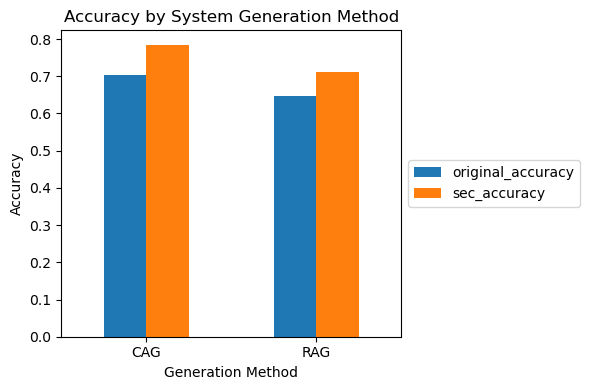

In [311]:
ax = summary_by_system[['original_accuracy', 'sec_accuracy']].plot(kind='bar', figsize=(6, 4))
plt.title("Accuracy by System Generation Method")
plt.ylabel("Accuracy")
plt.xlabel("Generation Method") 
plt.xticks(rotation=0)

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5)) 

plt.tight_layout()  
plt.show()


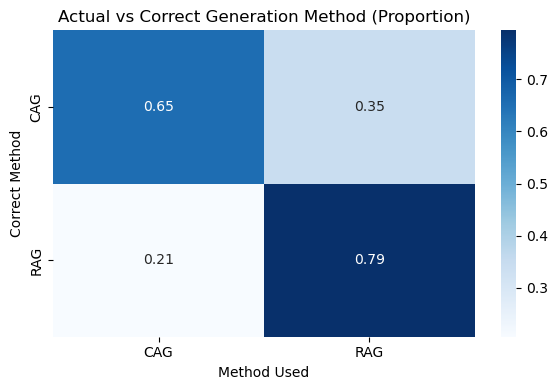

In [317]:

conf_matrix = pd.crosstab(df['method_sb'], df['method_used'])
conf_matrix_percent = conf_matrix.div(conf_matrix.sum(axis=1), axis=0)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_percent, annot=True, cmap="Blues", fmt=".2f")

plt.title("Actual vs Correct Generation Method (Proportion)")
plt.xlabel("Method Used")
plt.ylabel("Correct Method")
plt.tight_layout()
plt.show()

In [166]:
sampling_df = df[df['gen_method'] == 'sampling']
summary_by_sampling = sampling_df.groupby(['temperature', 'top_k']).agg(
    original_accuracy=('is_good_enough', 'mean'),
    secondary_accuracy=('validate_secondary', 'mean'),
    avg_response_time=('response_time', 'mean'),
    count=('query', 'count')
).reset_index()


In [90]:
summary_by_round

,test_round,original_accuracy,sec_accuracy,method_correct,should_flip,actually_flipped,avg_response_time,avg_response_time_cag,avg_response_time_rag
0,0,0.750000,0.850000,0.650000,3,0,21.749539,31.594681,12.842029
1,1,0.600000,0.775000,0.775000,2,0,15.062571,14.531845,15.542752
2,2,0.725000,0.725000,0.775000,9,0,19.036708,28.825287,9.248129
3,3,0.700000,0.800000,0.650000,8,0,17.089530,25.822619,11.267471
4,4,0.708333,0.750000,0.666667,3,0,10.526749,15.928863,7.285480
...,...,...,...,...,...,...,...,...,...
61,61,0.666667,0.666667,0.555556,2,0,7.633762,5.708383,8.859003
62,62,0.562500,0.656250,0.718750,4,0,14.034281,8.136914,18.069322
63,63,0.675000,0.800000,0.725000,3,0,10.067769,11.123031,9.204373
64,64,0.666667,0.750000,0.791667,5,0,10.294907,6.514882,11.554915


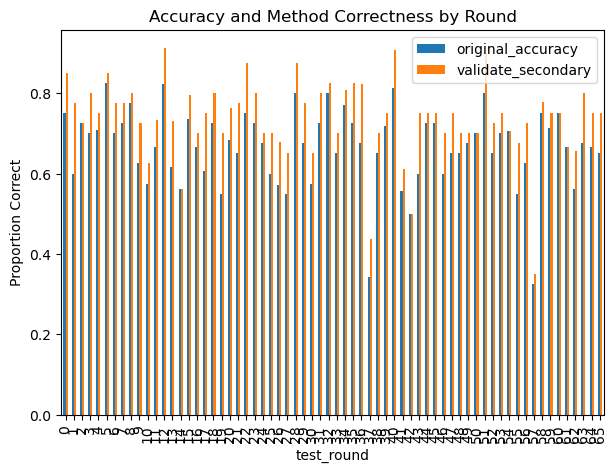

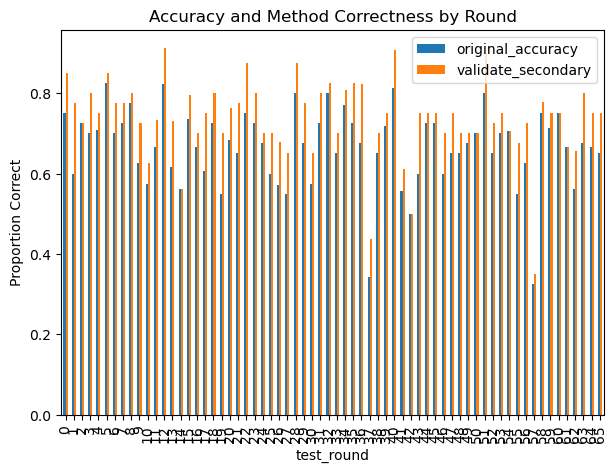

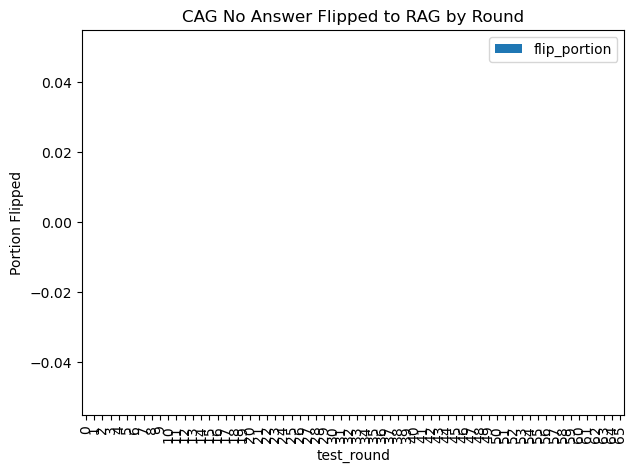

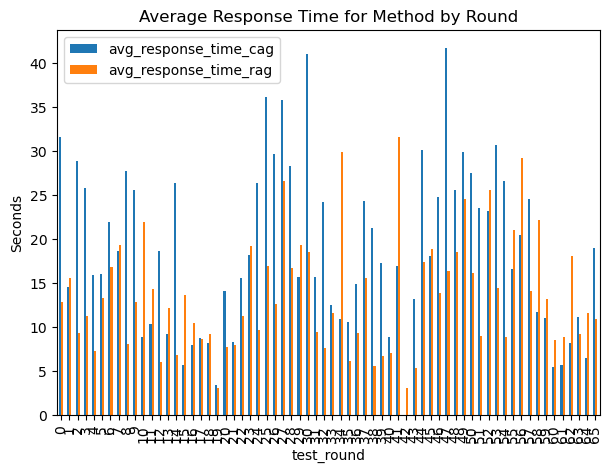

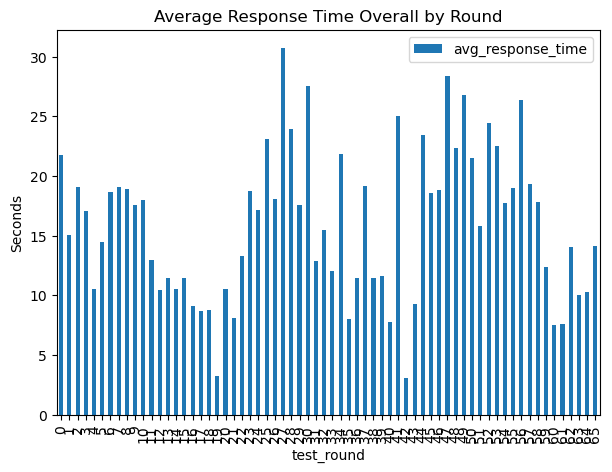

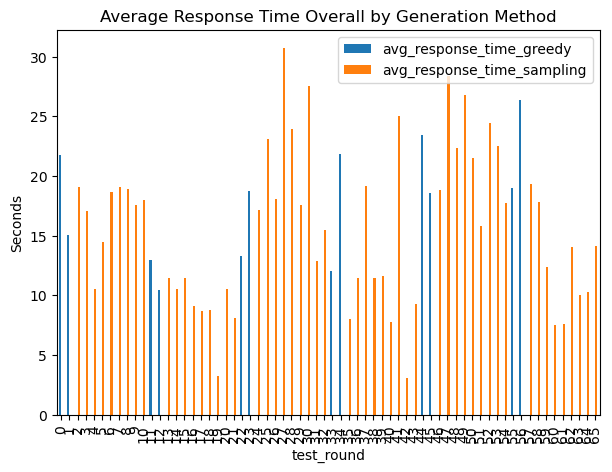

In [305]:
import matplotlib.pyplot as plt
import seaborn as sns

fsize = (7, 5)
summary_by_round[['test_round', 'original_accuracy', 'validate_secondary']].plot(x='test_round', kind='bar', figsize=fsize)
#plt.figure(figsize=(20, 5))
plt.title("Accuracy and Method Correctness by Round")
plt.ylabel("Proportion Correct")
plt.show()

# accuracy and Method Correctness
summary_by_round[['test_round', 'original_accuracy', 'validate_secondary']].plot(x='test_round', kind='bar', figsize=fsize)
#plt.figure(figsize=(20, 5))
plt.title("Accuracy and Method Correctness by Round")
plt.ylabel("Proportion Correct")
plt.show()


# flips
summary_by_round['flip_portion'] = summary_by_round['actually_flipped']/summary_by_round['should_flip']
summary_by_round[['test_round', 'flip_portion']].plot(x='test_round', kind='bar', figsize=fsize)
plt.title("CAG No Answer Flipped to RAG by Round")
plt.ylabel("Portion Flipped")
plt.show()

# response times by method
summary_by_round[['test_round', 'avg_response_time_cag', 'avg_response_time_rag']].plot(x='test_round', kind='bar', figsize=fsize)
plt.title("Average Response Time for Method by Round")
plt.ylabel("Seconds")
plt.show()
# response times overall
summary_by_round[['test_round', 'avg_response_time',]].plot(x='test_round', kind='bar', figsize=fsize)
plt.title("Average Response Time Overall by Round")
plt.ylabel("Seconds")
plt.show()
# response times overall
summary_by_round[['test_round', 'avg_response_time_greedy', 'avg_response_time_sampling',]].plot(x='test_round', kind='bar', figsize=fsize)
plt.title("Average Response Time Overall by Generation Method")
plt.ylabel("Seconds")
plt.show()

In [159]:
pivoted.head()

gen_method,Greedy,sampling
test_round,,
0,21.749539,NaN
1,15.062571,NaN
2,NaN,19.036708
3,NaN,17.089530
4,NaN,10.526749


In [70]:
df.head(2)

,test_method,doc,query,answer_true,answer_gen,results,is_good_enough,validate_secondary,sys_correct,method_used,...,cnt_docs,cnt_refdoc_chars,cache_tok,test_round,divisor,max_cache_tokens,gen_method,temperature,top_k,char_bin
0,"{'divisor': 20, 'max_cache_tokens': 6400, 'gen...",What happens after I submit my application to ...,What are the exact reasons for the denial of m...,As Northeastern's OGS assistant I do not have ...,Applications for the STEM Extension are often...,"{'token_f1': 0.0, 'embedding_similarity': 0.17...",False,True,True,RAG,...,5,513,6290,0,20,6400,Greedy,NaN,NaN,short
1,"{'divisor': 20, 'max_cache_tokens': 6400, 'gen...",Bachelor’s Completion If you have already begu...,What type of community will I join if I enroll...,"You will join a community of students, both do...","A community of students, both domestic and in...","{'token_f1': 0.896551724137931, 'embedding_sim...",True,True,True,RAG,...,5,400,6290,0,20,6400,Greedy,NaN,NaN,short


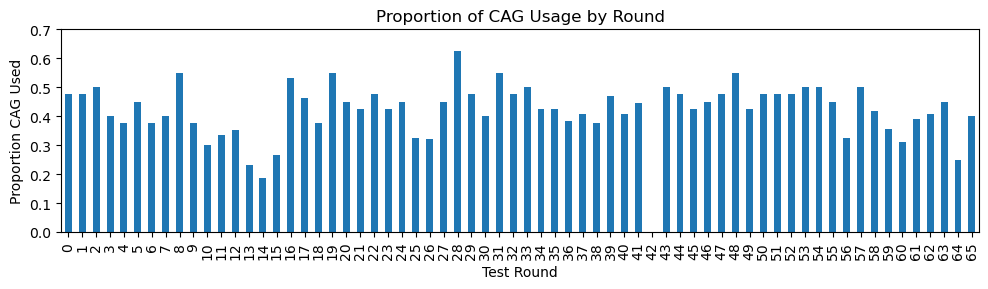

In [88]:
df['is_cag'] = df['method_used'] == 'CAG'
pivoted = df.groupby(['test_round'])['is_cag'].mean() #.unstack()
pivoted.plot(kind='bar', figsize=(10, 3))
plt.title("Proportion of CAG Usage by Round")
plt.ylabel("Proportion CAG Used")
plt.xlabel("Test Round")
plt.xticks(rotation=90)
plt.ylim(0, .7)
#plt.legend(title="Gen Method", loc='upper right')
plt.tight_layout()
plt.show()


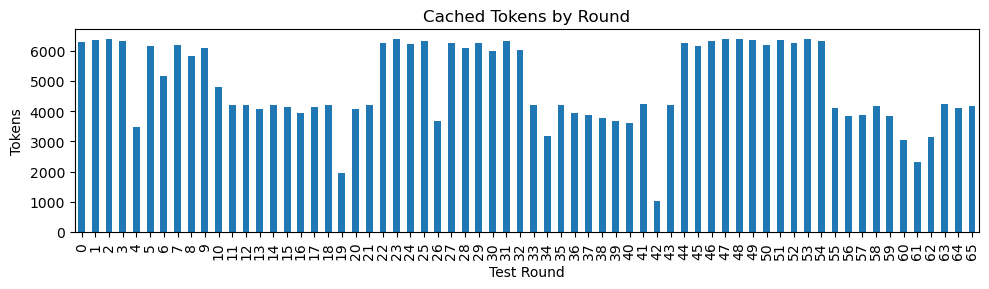

In [96]:
pivoted = df.groupby(['test_round'])['cache_tok'].mean() #.unstack()
pivoted.plot(kind='bar', figsize=(10, 3))
plt.title("Cached Tokens by Round")
plt.ylabel("Tokens")
plt.xlabel("Test Round")
plt.xticks(rotation=90)
# plt.legend(title=None, loc='upper right')
plt.tight_layout()
plt.show()

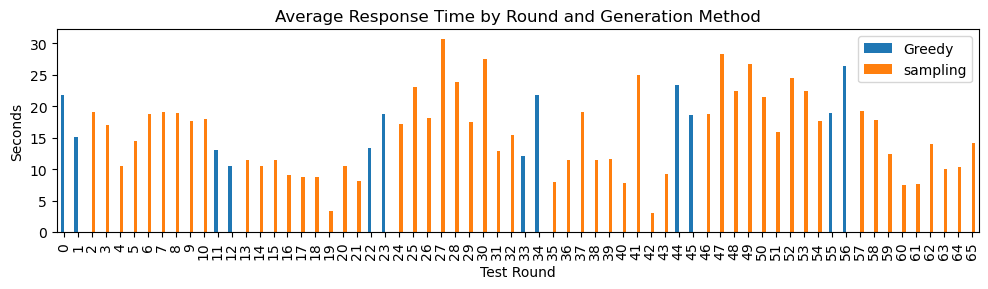

In [98]:
pivoted = df.sort_values(by='gen_method').groupby(['test_round', 'gen_method'])['response_time'].mean().unstack()
pivoted.plot(kind='bar', figsize=(10, 3))
plt.title("Average Response Time by Round and Generation Method")
plt.ylabel("Seconds")
plt.xlabel("Test Round")
plt.xticks(rotation=90)
plt.legend(title=None, loc='upper right')
plt.tight_layout()
plt.show()

In [22]:
import matplotlib.pyplot as plt
summary_by_round[['original_accuracy', 'sec_accuracy']].plot(kind='bar', figsize=(12, 4))
plt.title("Accuracy by Test Round (Original vs Secondary)")
plt.ylabel("Accuracy")
plt.xlabel("Test Round")
plt.xticks(rotation=90)
plt.show()


NameError: name 'summary_by_round' is not defined

In [ ]:
import matplotlib.pyplot as plt
summary_by_round[['original_accuracy', 'sec_accuracy']].plot(kind='bar', figsize=(12, 4))
plt.title("Accuracy by Test Round (Original vs Secondary)")
plt.ylabel("Accuracy")
plt.xlabel("Test Round")
plt.xticks(rotation=90)
plt.show()


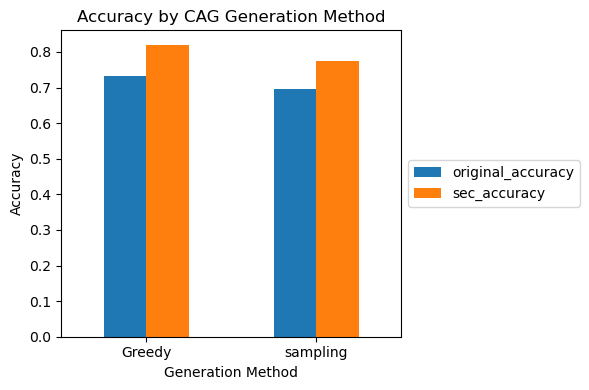

In [299]:
ax = summary_by_method[['original_accuracy', 'sec_accuracy']].plot(kind='bar', figsize=(6, 4))
plt.title("Accuracy by CAG Generation Method")
plt.ylabel("Accuracy")
plt.xlabel("Generation Method")
plt.xticks(rotation=0)

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5)) 

plt.tight_layout()  
plt.show()


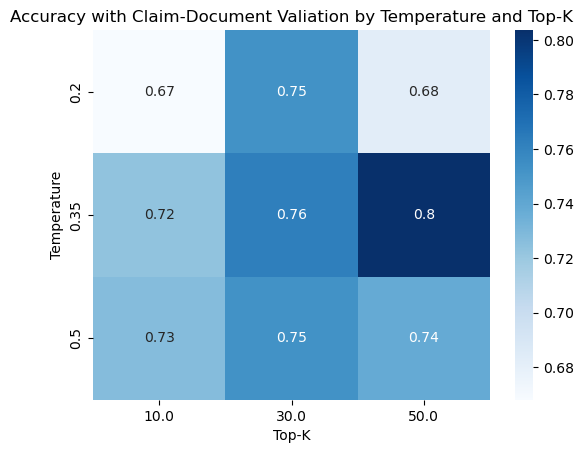

In [168]:
import seaborn as sns
import matplotlib.pyplot as plt

pivoted = summary_by_sampling.pivot(index="temperature", columns="top_k", values="secondary_accuracy")
sns.heatmap(pivoted, annot=True, cmap="Blues")
plt.title("Accuracy with Claim-Document Valiation by Temperature and Top-K")
plt.xlabel("Top-K")
plt.ylabel("Temperature")
plt.show()


In [125]:
summary_by_bestsample = df.loc[(df.temperature == 0.35) & (df.top_k == 50)].groupby('test_round').agg(
    original_accuracy=('is_good_enough', 'mean'),
    sec_accuracy=('validate_secondary', 'mean'),
    method_correct=('sys_correct', 'mean'),
    should_flip=('flipped', 'sum'),
    actually_flipped=('method_used', lambda x: ((df.loc[x.index, 'method_sb'] == 'CAG') & 
                                                 (df.loc[x.index, 'answer_true'] == "No Answer") &
                                                 (x == 'RAG')).sum()),
    avg_response_time=('response_time', 'mean'),
    avg_response_time_cag=('response_time', lambda x: df.loc[x.index][df['method_used'] == 'CAG']['response_time'].mean()),
    avg_response_time_rag=('response_time', lambda x: df.loc[x.index][df['method_used'] == 'RAG']['response_time'].mean()),
).reset_index()


C:\Users\dfraz\AppData\Local\Temp\ipykernel_14948\3079623416.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  avg_response_time_cag=('response_time', lambda x: df.loc[x.index][df['method_used'] == 'CAG']['response_time'].mean()),
C:\Users\dfraz\AppData\Local\Temp\ipykernel_14948\3079623416.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  avg_response_time_cag=('response_time', lambda x: df.loc[x.index][df['method_used'] == 'CAG']['response_time'].mean()),
C:\Users\dfraz\AppData\Local\Temp\ipykernel_14948\3079623416.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  avg_response_time_cag=('response_time', lambda x: df.loc[x.index][df['method_used'] == 'CAG']['response_time'].mean()),
C:\Users\dfraz\AppData\Local\Temp\ipykernel_14948\3079623416.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  avg_response_time_cag=('response_time', lambda x: df.loc

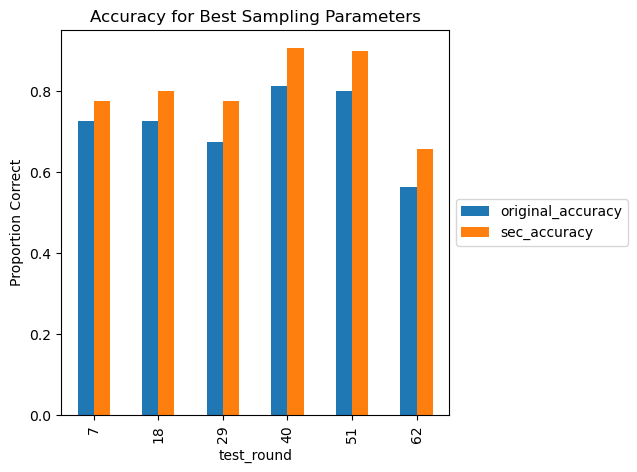

In [275]:
fsize = (5, 5)
summary_by_bestsample[['test_round', 'original_accuracy', 'sec_accuracy']].plot(x='test_round', kind='bar', figsize=fsize)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5)) 
plt.title("Accuracy for Best Sampling Parameters")
plt.ylabel("Proportion Correct")
plt.show()

In [169]:
summary_by_greedy = df.loc[(df.gen_method == 'Greedy')].groupby('test_round').agg(
    original_accuracy=('is_good_enough', 'mean'),
    sec_accuracy=('validate_secondary', 'mean'),
    method_correct=('sys_correct', 'mean'),
    should_flip=('flipped', 'sum'),
    actually_flipped=('method_used', lambda x: ((df.loc[x.index, 'method_sb'] == 'CAG') & 
                                                 (df.loc[x.index, 'answer_true'] == "No Answer") &
                                                 (x == 'RAG')).sum()),
    avg_response_time=('response_time', 'mean'),
    avg_response_time_cag=('response_time', lambda x: df.loc[x.index][df['method_used'] == 'CAG']['response_time'].mean()),
    avg_response_time_rag=('response_time', lambda x: df.loc[x.index][df['method_used'] == 'RAG']['response_time'].mean()),
).reset_index()

C:\Users\dfraz\AppData\Local\Temp\ipykernel_14948\1926711620.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  avg_response_time_cag=('response_time', lambda x: df.loc[x.index][df['method_used'] == 'CAG']['response_time'].mean()),
C:\Users\dfraz\AppData\Local\Temp\ipykernel_14948\1926711620.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  avg_response_time_cag=('response_time', lambda x: df.loc[x.index][df['method_used'] == 'CAG']['response_time'].mean()),
C:\Users\dfraz\AppData\Local\Temp\ipykernel_14948\1926711620.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  avg_response_time_cag=('response_time', lambda x: df.loc[x.index][df['method_used'] == 'CAG']['response_time'].mean()),
C:\Users\dfraz\AppData\Local\Temp\ipykernel_14948\1926711620.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  avg_response_time_cag=('response_time', lambda x: df.loc

In [175]:
print(summary_by_bestsample.sec_accuracy.mean())
summary_by_greedy.sec_accuracy.mean()

0.8020833333333334


0.7793991955756662

C:\Users\dfraz\AppData\Local\Temp\ipykernel_14948\1458907064.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  avg_response_time_cag=('response_time', lambda x: df.loc[x.index][df['method_used'] == 'CAG']['response_time'].mean()),
C:\Users\dfraz\AppData\Local\Temp\ipykernel_14948\1458907064.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  avg_response_time_cag=('response_time', lambda x: df.loc[x.index][df['method_used'] == 'CAG']['response_time'].mean()),
C:\Users\dfraz\AppData\Local\Temp\ipykernel_14948\1458907064.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  avg_response_time_cag=('response_time', lambda x: df.loc[x.index][df['method_used'] == 'CAG']['response_time'].mean()),
C:\Users\dfraz\AppData\Local\Temp\ipykernel_14948\1458907064.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  avg_response_time_cag=('response_time', lambda x: df.loc

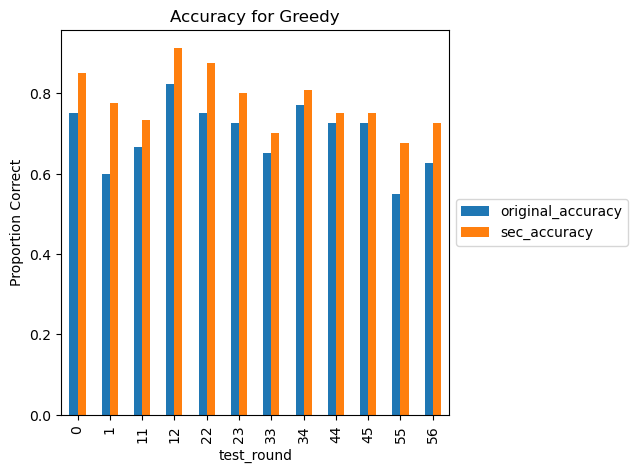

In [145]:

fsize = (5, 5)
summary_by_greedy[['test_round', 'original_accuracy', 'sec_accuracy']].plot(x='test_round', kind='bar', figsize=fsize)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.title("Accuracy for Greedy")
plt.ylabel("Proportion Correct")
plt.show()

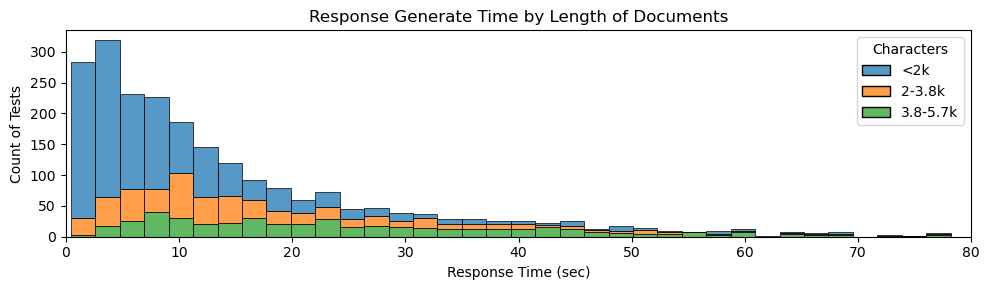

In [152]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

bin_labels = ['<2k', '2-3.8k', '3.8-5.7k']
df['Characters'] = pd.cut(df['cnt_refdoc_chars'], bins=3, labels=bin_labels)
df_clean = df.dropna(subset=['char_bin'])

# Plot
plt.figure(figsize=(10, 3))
ax = sns.histplot(
    data=df_clean,
    x='response_time',
    hue='Characters',
    bins=100,
    multiple='stack'
)

plt.title("Response Generate Time by Length of Documents")
plt.xlabel("Response Time (sec)")
plt.ylabel("Count of Tests")
plt.xlim(0, 80)  # cut off x-axis at 100 seconds

# Custom legend if needed
if not ax.get_legend():
    from matplotlib.patches import Patch
    handles = [Patch(color=col, label=lab) for col, lab in zip(sns.color_palette(n_colors=3), bin_labels)]
    plt.legend(handles=handles, title="Doc Length Bin", loc='upper right')
#else:
    #plt.legend(title="Doc Length Bin", loc='upper right')

plt.tight_layout()
plt.show()


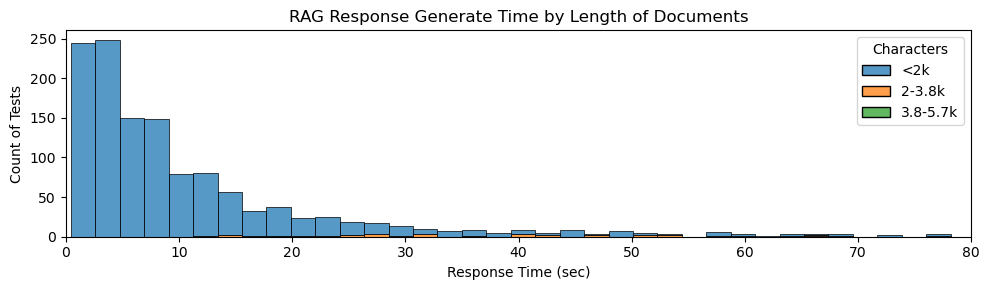

In [154]:
df['Characters'] = pd.cut(df.loc[(df.method_used == 'RAG')]['cnt_refdoc_chars'], bins=3, labels=bin_labels)
df_clean = df.dropna(subset=['char_bin'])

# Plot
plt.figure(figsize=(10, 3))
ax = sns.histplot(
    data=df_clean,
    x='response_time',
    hue='Characters',
    bins=100,
    multiple='stack'
)

plt.title("RAG Response Generate Time by Length of Documents")
plt.xlabel("Response Time (sec)")
plt.ylabel("Count of Tests")
plt.xlim(0, 80)  
if not ax.get_legend():
    print('did')
    from matplotlib.patches import Patch
    handles = [Patch(color=col, label=lab) for col, lab in zip(sns.color_palette(n_colors=3), bin_labels)]
    plt.legend(handles=handles, title="Doc Length Bin", loc='upper right')
plt.tight_layout()
plt.show()


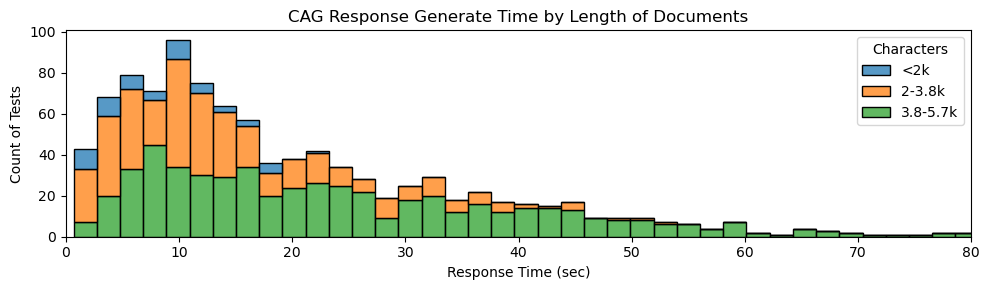

In [162]:

df['Characters'] = pd.cut(df.loc[(df.method_used == 'CAG')]['cnt_refdoc_chars'], bins=3, labels=bin_labels))
df_clean = df.dropna(subset=['Characters'])

# Plot
plt.figure(figsize=(10, 3))
ax = sns.histplot(
    data=df_clean,
    x='response_time',
    hue='Characters',
    bins=48,
    multiple='stack'
)

plt.title("CAG Response Generate Time by Length of Documents")
plt.xlabel("Response Time (sec)")
plt.ylabel("Count of Tests")
#plt.ylim(0, 500) 
plt.xlim(0, 80)  

if not ax.get_legend():
    from matplotlib.patches import Patch
    handles = [Patch(color=col, label=lab) for col, lab in zip(sns.color_palette(n_colors=3), bin_labels)]
    plt.legend(handles=handles, title="Doc Length Bin", loc='upper right')

plt.tight_layout()
plt.show()


In [144]:
df['char_bin'].value_counts()

char_bin
short     1272
medium     556
long       466
Name: count, dtype: int64

In [146]:
bins = pd.cut(df['cnt_refdoc_chars'], bins=3)
interval_counts = bins.value_counts().sort_index()
print(interval_counts)

cnt_refdoc_chars
(59.399, 1932.0]    1272
(1932.0, 3799.0]     556
(3799.0, 5666.0]     466
Name: count, dtype: int64


In [267]:
bins = pd.cut(df.loc[(df.method_used == 'RAG')]['cnt_refdoc_chars'], bins=3, labels=bin_labels)
interval_counts = bins.value_counts().sort_index()
print(interval_counts)

cnt_refdoc_chars
short     1249
medium      52
long         6
Name: count, dtype: int64


In [269]:
bins = pd.cut(df.loc[(df.method_used == 'CAG')]['cnt_refdoc_chars'], bins=3, labels=bin_labels)
interval_counts = bins.value_counts().sort_index()
print(interval_counts)

cnt_refdoc_chars
short      56
medium    379
long      552
Name: count, dtype: int64


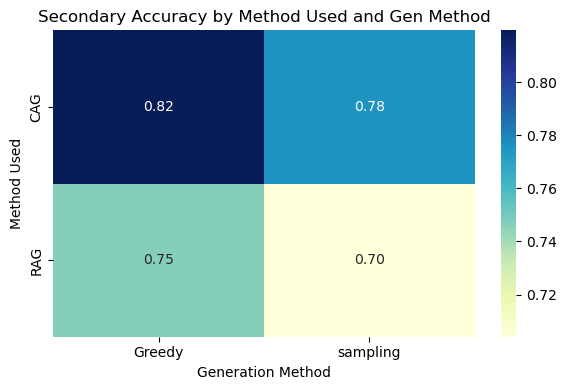

In [273]:

heatmap_data = df.groupby(['method_used', 'gen_method'])['validate_secondary'].mean().unstack()
plt.figure(figsize=(6, 4))
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Secondary Accuracy by Method Used and Gen Method")
plt.xlabel("Generation Method")
plt.ylabel("Method Used")
plt.tight_layout()
plt.show()

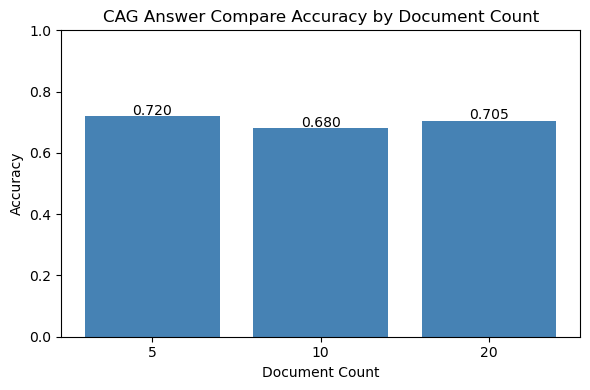

In [54]:
data = {5: 0.72, 10: 0.68, 20: 0.705}
x = list(data.keys())
y = list(data.values())

plt.figure(figsize=(6, 4))
plt.bar(range(len(x)), y, tick_label=x, color='steelblue')
plt.ylabel("Accuracy")
plt.xlabel("Document Count")
plt.title("CAG Answer Compare Accuracy by Document Count")

for i, val in enumerate(y):
    plt.text(i, val + 0.005, f"{val:.3f}", ha='center')

plt.ylim(0, 1) 
plt.tight_layout()
plt.show()


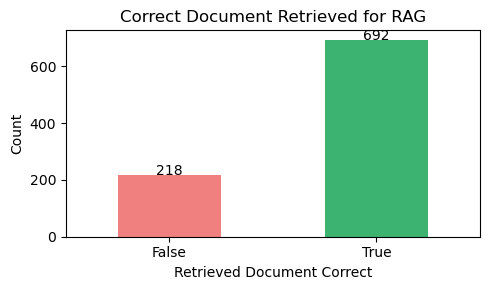

In [64]:

rag_df = df[df['method_used'] == 'RAG']

# Count how often rag_right is True/False
counts = rag_df['rag_right'].value_counts().sort_index()

plt.figure(figsize=(5, 3))
counts.plot(kind='bar', color=['lightcoral', 'mediumseagreen'])
plt.title("Correct Document Retrieved for RAG")
plt.xlabel("Retrieved Document Correct")
plt.ylabel("Count")
plt.xticks([0, 1], labels=["False", "True"], rotation=0)

for i, v in enumerate(counts):
    plt.text(i, v + 1, str(v), ha='center')

plt.tight_layout()
plt.show()
